## Imports

In [1]:
# !pip install imbalanced-learn
# !pip install xgboost

In [2]:
import os
import pandas as pd
import numpy as np
import hashlib
import io
import json
import pickle
import requests
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import ks_2samp
from plotchecker import LinePlotChecker, ScatterPlotChecker, BarPlotChecker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler
# from xgboost import XGBRegressor
# from imblearn.pipeline import Pipeline as ImbPipeline  # Use imbalanced-learn's pipeline

# from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
## Know which packages i have installed
#pip freeze

## Read data

In [4]:
df_prod_sales = pd.read_csv("train/product_structures_sales.csv")
df_prices = pd.read_csv("train/product_prices_leaflets.csv")
df_chains = pd.read_csv("train/chain_campaigns.csv")

## Understand the data

### Shape

In [5]:
df_prod_sales.shape

(1864594, 7)

In [6]:
df_prices.shape

(3112140, 7)

In [7]:
df_chains.shape

(99, 4)

### Dtypes

In [8]:
df_prod_sales.dtypes

structure_level_4      int64
structure_level_3      int64
structure_level_2      int64
structure_level_1      int64
sku                    int64
time_key               int64
quantity             float64
dtype: object

In [9]:
df_prices.dtypes

sku             int64
time_key        int64
competitor     object
pvp_was       float64
discount      float64
flag_promo      int64
leaflet        object
dtype: object

In [10]:
df_chains.dtypes

competitor        object
start_date        object
end_date          object
chain_campaign    object
dtype: object

### Duplicated data

- No duplicated data

In [11]:
df_prod_sales.duplicated().sum()

0

In [12]:
df_prices.duplicated().sum()

0

In [13]:
df_chains.duplicated().sum()

0

### Null data

In [14]:
df_prod_sales.isnull().sum().sort_values(ascending=False)

structure_level_4    0
structure_level_3    0
structure_level_2    0
structure_level_1    0
sku                  0
time_key             0
quantity             0
dtype: int64

In [15]:
df_prices.isnull().sum().sort_values(ascending=False)

leaflet       2510555
sku                 0
time_key            0
competitor          0
pvp_was             0
discount            0
flag_promo          0
dtype: int64

In [16]:
df_chains.isnull().sum().sort_values(ascending=False)

competitor        0
start_date        0
end_date          0
chain_campaign    0
dtype: int64

## Fix data types
- Create date_key column using time_key
- Structure levels as strings

In [17]:
df_prod_sales['date'] = pd.to_datetime(df_prod_sales['time_key'].astype(str), format='%Y%m%d')
df_prices['date'] = pd.to_datetime(df_prices['time_key'].astype(str), format='%Y%m%d')
df_chains['start_date'] = pd.to_datetime(df_chains['start_date'])
df_chains['end_date'] = pd.to_datetime(df_chains['end_date'])

df_prod_sales['structure_level_1'] = df_prod_sales['structure_level_1'].astype("str")
df_prod_sales['structure_level_2'] = df_prod_sales['structure_level_2'].astype("str")
df_prod_sales['structure_level_3'] = df_prod_sales['structure_level_3'].astype("str")
df_prod_sales['structure_level_4'] = df_prod_sales['structure_level_4'].astype("str")

In [18]:
df_prod_sales.head()

,structure_level_4,structure_level_3,structure_level_2,structure_level_1,sku,time_key,quantity,date
0,3020206,30202,302,3,3111,20230618,18.6840,2023-06-18
1,3020608,30206,302,3,3278,20240731,396.1008,2024-07-31
2,3020809,30208,302,3,3603,20230807,6.2280,2023-08-07
3,3020608,30206,302,3,4604,20230131,27.4032,2023-01-31
4,3040808,30408,304,3,3041,20230906,6.2280,2023-09-06


In [19]:
df_prod_sales.dtypes

structure_level_4            object
structure_level_3            object
structure_level_2            object
structure_level_1            object
sku                           int64
time_key                      int64
quantity                    float64
date                 datetime64[ns]
dtype: object

In [20]:
df_prices.dtypes

sku                    int64
time_key               int64
competitor            object
pvp_was              float64
discount             float64
flag_promo             int64
leaflet               object
date          datetime64[ns]
dtype: object

In [21]:
df_chains.dtypes

competitor                object
start_date        datetime64[ns]
end_date          datetime64[ns]
chain_campaign            object
dtype: object

## Combine the data

In [22]:
# Explode chain_campaigns by date
df_chains_date = df_chains.copy()
df_chains_date['date_range'] = df_chains_date.apply(lambda row: pd.date_range(start=row['start_date'], end=row['end_date']), axis=1)
df_chains_date = (df_chains_date.explode('date_range')
                                 .rename(columns={'date_range': 'date'})
                                 .drop(['start_date', 'end_date'], axis=1))

In [23]:
# Join the 3 datasets together
### keys: sku x time_key x competitor 
df = (df_prices.merge(df_prod_sales.drop('time_key', axis=1), on=['sku', 'date'], how='left')
               .merge(df_chains_date, on=['competitor', 'date'], how='left')
     )
## Add column pvp_is
df['pvp_is'] = df['pvp_was']*(1-df['discount'])

## ignora rows where quantity = 0 in company
df = df.dropna(subset=['quantity'])

In [24]:
df.loc[df.sku==3949].sort_values(by=['time_key'])
# df.head()


,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,date,structure_level_4,structure_level_3,structure_level_2,structure_level_1,quantity,chain_campaign,pvp_is
814078,3949,20230103,competitorB,48.43,0.1076,1,NaN,2023-01-03,1010407,10104,101,1,5748.169968,NaN,43.218932
314451,3949,20230103,competitorA,51.90,0.0000,0,NaN,2023-01-03,1010407,10104,101,1,5748.169968,NaN,51.900000
2680482,3949,20230103,chain,39.75,0.0000,0,weekly,2023-01-03,1010407,10104,101,1,5748.169968,C1,39.750000
1676547,3949,20230104,chain,39.75,0.0000,0,weekly,2023-01-04,1010407,10104,101,1,5044.941576,C1,39.750000
232774,3949,20230104,competitorB,48.43,0.1076,1,NaN,2023-01-04,1010407,10104,101,1,5044.941576,NaN,43.218932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985899,3949,20241027,competitorA,51.90,0.0000,0,NaN,2024-10-27,1010407,10104,101,1,8435.726352,A2,51.900000
212825,3949,20241027,chain,51.90,0.0000,0,NaN,2024-10-27,1010407,10104,101,1,8435.726352,C1,51.900000
2265233,3949,20241028,competitorB,51.90,0.0000,0,weekly,2024-10-28,1010407,10104,101,1,5949.434016,NaN,51.900000
168915,3949,20241028,competitorA,51.90,0.0000,0,NaN,2024-10-28,1010407,10104,101,1,5949.434016,NaN,51.900000


## Simple visualizations

#### Sales evolution

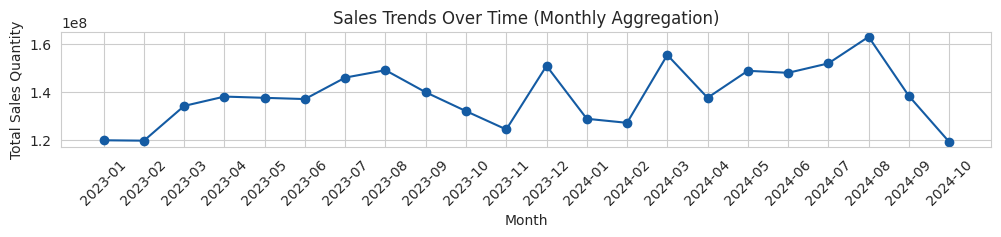

<Figure size 640x480 with 0 Axes>

In [116]:
# Aggregate sales quantity per month
df_monthly = df.groupby(df['date'].dt.to_period('M'))['quantity'].sum().reset_index()
df_monthly['date'] = df_monthly['date'].astype(str)  # Convert period to string for plotting
# df_monthly = df.copy()
# df_monthly = df_monthly[['sku','date','quantity']]

# Plot the aggregated sales trends
plt.figure(figsize=(12, 1.5))
plt.plot(df_monthly['date'], df_monthly['quantity'], marker='o', linestyle='-', color='#145ba3')

# Formatting the plot
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Sales Quantity")
plt.title("Sales Trends Over Time (Monthly Aggregation)")
plt.grid(True)
plt.show()
plt.savefig("sales_trends.png", dpi=300, bbox_inches="tight")

#### Number of skus, competitors coverage and sales

The chain has  3543  unique skus across  3  product structures of level 1
The chain has a total of  1252376322  unites sold in the data horizon


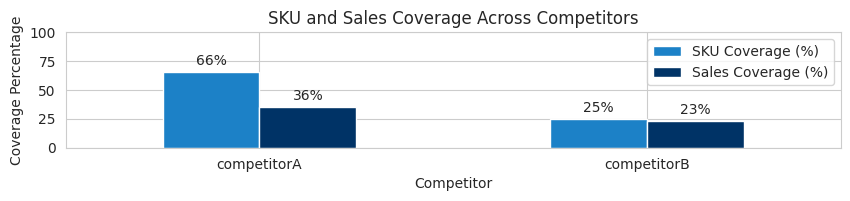

<Figure size 1000x200 with 0 Axes>

In [112]:
# Exclude rows where competitor price is NaN
df_filtered = df.dropna(subset=['pvp_was'])

# Total number of unique SKUs in the chain
total_skus = df_filtered[df_filtered['competitor'] == 'chain']['sku'].nunique()
number_struct_level1 = df_filtered[df_filtered['competitor'] == 'chain']['structure_level_1'].nunique()
print("The chain has ", total_skus, " unique skus across ", number_struct_level1, " product structures of level 1")
total_qty = int(df_filtered[df_filtered['competitor'] == 'chain']['quantity'].sum())
print("The chain has a total of ", total_qty, " unites sold in the data horizon")

# SKU coverage per competitor (only for SKUs that have a price)
sku_coverage = df_filtered[df_filtered['competitor'] != 'chain'].groupby('competitor')['sku'].nunique() / total_skus * 100

# Sales coverage per competitor (only for SKUs that have a price)
sales_coverage = df_filtered[df_filtered['competitor'] != 'chain'].groupby('competitor')['quantity'].sum() / df_filtered['quantity'].sum() * 100

# Create DataFrame for visualization
coverage_df = pd.DataFrame({'SKU Coverage (%)': sku_coverage, 'Sales Coverage (%)': sales_coverage})

# Set Seaborn style and palette
sns.set_style("whitegrid")
# Define custom colors: shades of blue + black
# custom_colors = ['#1f77b4', '#0055A4', '#003366', '#000000']  # You can adjust/add based on number of competitors
custom_colors = ['#1c81c7', '#003366']  # You can adjust/add based on number of competitors

# Create bar plot with custom colors
ax = coverage_df.plot(kind='bar', figsize=(10, 1.5), color=custom_colors[:coverage_df.shape[1]])


# Create the bar plot
# ax = coverage_df.plot(kind='bar', figsize=(10, 2))
ax.set_ylim(0, 100)
# Add % labels
for container in ax.containers:
    labels = [f'{v.get_height() :.0f}%' for v in container]
    ax.bar_label(container, labels=labels, padding=3)

# Formatting
plt.title("SKU and Sales Coverage Across Competitors")
plt.xlabel("Competitor")
plt.ylabel("Coverage Percentage")
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.savefig("skus_coverage_comp.png", dpi=300, bbox_inches="tight")
plt.figure(figsize=(10, 2))

# Show the plot
plt.show()

#### Leaflets and its frequency

In [99]:
df['date'].max()  ## 3 JAn until 28 october

Timestamp('2024-10-28 00:00:00')

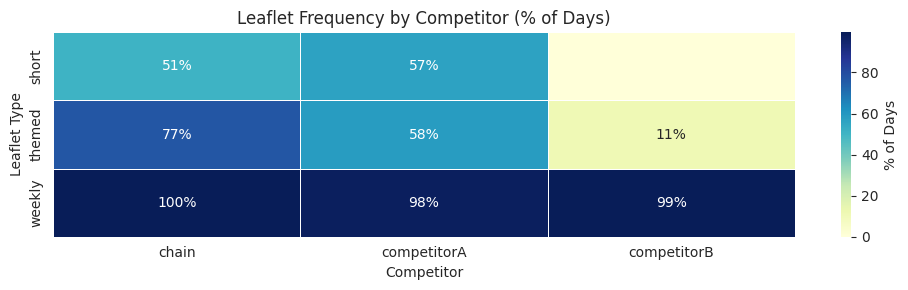

<Figure size 640x480 with 0 Axes>

In [102]:
# Remove rows where leaflet is NaN
df_leaflets = df.dropna(subset=['leaflet'])

# Total number of unique days in the dataset
total_days = df['date'].nunique()

# Calculate leaflet frequency (%) per competitor (how often each leaflet type appears in the dataset)
leaflet_counts = df_leaflets.groupby(['competitor', 'leaflet'])['date'].nunique().reset_index()
leaflet_counts['frequency'] = (leaflet_counts['date'] / total_days) * 100  # Convert count to percentage

# Pivot the data
heatmap_data = leaflet_counts.pivot(index='leaflet', columns='competitor', values='frequency').fillna(0)

# Create annotation labels with % sign
annot_labels = heatmap_data.map(lambda x: f"{int(round(x))}%" if x > 0 else "")

# Plot heatmap with % annotations
plt.figure(figsize=(10, 3))
sns.heatmap(
    heatmap_data,
    annot=annot_labels,
    fmt="",  # not needed because we provide the strings manually
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': '% of Days'}
)
plt.title("Leaflet Frequency by Competitor (% of Days)")
plt.xlabel("Competitor")
plt.ylabel("Leaflet Type")
plt.tight_layout()
plt.show()
plt.savefig("leaflet_frequency.png", dpi=300, bbox_inches="tight")

In [162]:
df.loc[((df.sku==3579) & (df.time_key>=20240501) & (df.time_key<=20240601)& (df.competitor=='chain'))].sort_values(by=['sku', 'competitor','date'])

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,date,structure_level_4,structure_level_3,structure_level_2,structure_level_1,quantity,chain_campaign,pvp_is,leaflet_change,group,leaflet_filled,leaflet_group
597810,3579,20240501,chain,64.05,0.0,0,NaN,2024-05-01,1020701,10207,102,1,11454.5376,C1,64.05,1,463,none,16
3111325,3579,20240502,chain,64.05,0.0,0,NaN,2024-05-02,1020701,10207,102,1,9796.6440,C1,64.05,1,464,none,16
107114,3579,20240503,chain,64.05,0.0,0,NaN,2024-05-03,1020701,10207,102,1,10499.1624,C1,64.05,1,465,none,16
3108227,3579,20240504,chain,64.05,0.0,0,NaN,2024-05-04,1020701,10207,102,1,15755.5944,C1,64.05,1,466,none,16
764873,3579,20240505,chain,64.05,0.0,0,NaN,2024-05-05,1020701,10207,102,1,10056.9744,C1,64.05,1,467,none,16
1806398,3579,20240506,chain,64.05,0.0,0,NaN,2024-05-06,1020701,10207,102,1,8428.9752,C1,64.05,1,468,none,16
927774,3579,20240507,chain,48.43,0.0,0,weekly,2024-05-07,1020701,10207,102,1,9599.8392,C1,48.43,1,469,weekly,17
2137150,3579,20240508,chain,48.43,0.0,0,weekly,2024-05-08,1020701,10207,102,1,10962.5256,C1,48.43,0,469,weekly,17
2023245,3579,20240509,chain,48.43,0.0,0,weekly,2024-05-09,1020701,10207,102,1,9907.5024,C1,48.43,0,469,weekly,17
787748,3579,20240510,chain,48.43,0.0,0,weekly,2024-05-10,1020701,10207,102,1,12153.3192,C1,48.43,0,469,weekly,17


In [159]:
df.dtypes

sku                           int64
time_key                      int64
competitor                   object
pvp_was                     float64
discount                    float64
flag_promo                    int64
leaflet                      object
date                 datetime64[ns]
structure_level_4            object
structure_level_3            object
structure_level_2            object
structure_level_1            object
quantity                    float64
chain_campaign               object
pvp_is                      float64
leaflet_change                int64
group                         int64
leaflet_filled               object
dtype: object

In [174]:
# df.loc[((df.sku==1185))]['quantity'].sum()

5677.4448

In [173]:
# df.loc[((df.sku==1185) & (df.flag_promo==1))]['quantity'].sum()

4146.602400000001

In [178]:
# leaflet_durations.loc[((leaflet_durations.leaflet_filled=='weekly') & (leaflet_durations.duration>7))]

,sku,competitor,leaflet_filled,leaflet_group,start_date,end_date,duration,total_quantity
79,1194,chain,weekly,3,2024-08-27,2024-09-09,14,1209.4776
168,1196,competitorA,weekly,2,2024-07-16,2024-08-05,21,637.7472
203,1200,chain,weekly,10,2024-10-08,2024-10-21,14,38.6136
221,1201,chain,weekly,10,2024-10-08,2024-10-21,14,910.5336
309,1231,chain,weekly,12,2024-09-30,2024-10-07,8,630.2736
...,...,...,...,...,...,...,...,...
143736,4732,competitorA,weekly,22,2023-12-19,2023-12-26,8,11250.2592
143750,4732,competitorA,weekly,52,2024-10-08,2024-10-21,14,7530.8976
143789,4735,chain,weekly,1,2023-01-03,2023-01-16,14,827.0784
143807,4735,chain,weekly,38,2023-05-09,2023-05-22,14,519.4152


In [176]:
# # Step 0: Make sure date is sorted properly
# df = df.sort_values(by=['sku', 'competitor', 'date'])

# # Step 1: Remove SKUs where more than 80% of sold quantity was under promo
# promo_ratios = (
#     df[df['competitor'] == 'chain']
#     .groupby('sku')[['flag_promo', 'quantity']]
#     .apply(lambda g: pd.Series({
#         'promo_quantity': g.loc[g['flag_promo'] == 1, 'quantity'].sum(),
#         'total_quantity': g['quantity'].sum()
#     }))
#     .reset_index()
# )
# promo_ratios['promo_share'] = promo_ratios['promo_quantity'] / promo_ratios['total_quantity']
# skus_to_exclude = promo_ratios.loc[promo_ratios['promo_share'] > 0.8, 'sku']
# df = df[~df['sku'].isin(skus_to_exclude)]

# # Step 2: Fill NaNs for leaflet to allow grouping
# df['leaflet_filled'] = df['leaflet'].fillna('none')

# # Step 3: Assign group ID for consecutive days with same leaflet type
# df['leaflet_group'] = (
#     df.groupby(['sku', 'competitor'])['leaflet_filled']
#     .transform(lambda x: (x != x.shift()).cumsum())
# )

# # Step 4: Calculate group duration and total quantity for each leaflet group
# leaflet_durations = (
#     df.groupby(['sku', 'competitor', 'leaflet_filled', 'leaflet_group'])
#     .agg(
#         start_date=('date', 'min'),
#         end_date=('date', 'max'),
#         duration=('date', lambda x: (x.max() - x.min()).days + 1),
#         total_quantity=('quantity', 'sum')
#     )
#     .reset_index()
# )

# # Step 5: Drop 'none' groups (no leaflet)
# leaflet_durations = leaflet_durations[leaflet_durations['leaflet_filled'] != 'none']

# # Step 6: Compute weighted average duration per SKU-competitor-leaflet
# sku_level = (
#     leaflet_durations
#     .groupby(['sku', 'competitor', 'leaflet_filled'])
#     .apply(lambda g: pd.Series({
#         'weighted_avg_duration_sku_level': (g['duration'] * g['total_quantity']).sum() / g['total_quantity'].sum(),
#         'total_quantity': g['total_quantity'].sum()
#     }))
#     .reset_index()
# )

# # Step 7: Compute weighted avg across SKUs by competitor and leaflet type
# final_result = (
#     sku_level
#     .groupby(['competitor', 'leaflet_filled'])
#     .apply(lambda g: (g['weighted_avg_duration_sku_level'] * g['total_quantity']).sum() / g['total_quantity'].sum())
#     .reset_index(name='weighted_avg_duration_final')
# )

# # Step 8 (optional): Sort result for readability
# final_result = final_result.sort_values(by=['competitor', 'leaflet_filled']).reset_index(drop=True)

# # Result: average leaflet durations, weighted by quantity sold
# print(final_result)

/tmp/ipykernel_688/3893349193.py:47: RuntimeWarning: invalid value encountered in scalar divide
  'weighted_avg_duration_sku_level': (g['duration'] * g['total_quantity']).sum() / g['total_quantity'].sum(),


    competitor leaflet_filled  weighted_avg_duration_final
0        chain          short                     3.458500
1        chain         themed                     7.936058
2        chain         weekly                    10.632512
3  competitorA          short                     1.913781
4  competitorA         themed                    12.366553
5  competitorA         weekly                     8.207113
6  competitorB         themed                     7.152362
7  competitorB         weekly                     8.843713


/tmp/ipykernel_688/3893349193.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/ipykernel_688/3893349193.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['weighted_avg_duration_sku_level'] * g['total_quantity']).sum() / g['total_quantity'].sum())


#### Chain campagins and its frequency

In [32]:
df_campaigns = df.copy()

df_campaigns = df_campaigns.sort_values(by=['sku', 'competitor', 'date'])

# Fill NaNs for grouping
df_campaigns['chain_campaign_filled'] = df_campaigns['chain_campaign'].fillna('none')

# Create a group for consecutive same-leaflet values
df_campaigns['chain_campaign_group'] = (
    df_campaigns.groupby(['sku', 'competitor'])['chain_campaign_filled']
    .transform(lambda x: (x != x.shift()).cumsum())
)

# Filter to actual leaflet entries
df_campaigns =df_campaigns[df_campaigns['chain_campaign_filled'] != 'none']

# Step 1–2: Calculate duration and quantity per group
campaing_durations = (
    df_campaigns.groupby(['sku', 'competitor', 'chain_campaign_filled', 'chain_campaign_group'])
    .agg(
        duration=('date', 'count'),
        total_quantity=('quantity', 'sum')
    )
    .reset_index()
    .rename(columns={'chain_campaign_filled': 'chain_campaign'})
)

# Step 3: Weighted average duration per sku x competitor x leaflet
avg_per_sku = (
    campaing_durations.groupby(['sku', 'competitor', 'chain_campaign'])
    .apply(lambda g: (g['duration'] * g['total_quantity']).sum() / g['total_quantity'].sum())
    .reset_index(name='weighted_avg_duration_sku_level')
)

# Step 4: Weighted average across SKUs (again weighted by quantity)
merged = avg_per_sku.merge(
    campaing_durations.groupby(['sku', 'competitor', 'chain_campaign'])['total_quantity'].sum().reset_index(),
    on=['sku', 'competitor', 'chain_campaign']
)

avg_final = (
    merged.groupby(['competitor', 'chain_campaign'])
    .apply(lambda g: (g['weighted_avg_duration_sku_level'] * g['total_quantity']).sum() / g['total_quantity'].sum())
    .reset_index(name='weighted_avg_duration_final')
)

/tmp/ipykernel_24635/1392176610.py:31: RuntimeWarning: invalid value encountered in scalar divide
  .apply(lambda g: (g['duration'] * g['total_quantity']).sum() / g['total_quantity'].sum())
/tmp/ipykernel_24635/1392176610.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['duration'] * g['total_quantity']).sum() / g['total_quantity'].sum())
/tmp/ipykernel_24635/1392176610.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns a

In [33]:
# Total number of unique days in the dataset
total_days = df['date'].nunique()

# Only keep rows where there's a valid campaign
df_campaign_days = df[df['chain_campaign'].notna()]

# Count how many unique days each campaign appears per competitor
campaign_day_counts = (
    df_campaign_days.groupby(['competitor', 'chain_campaign'])['date']
    .nunique()
    .reset_index(name='active_days')
)

# Calculate frequency (% of days)
campaign_day_counts['frequency'] = (campaign_day_counts['active_days'] / total_days) * 100

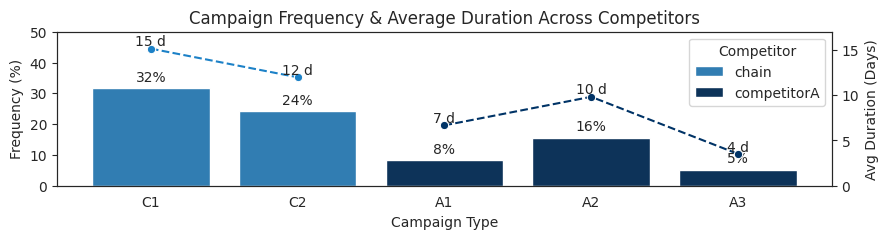

In [41]:
# Merge the data for both metrics (avg duration and frequency)
combined_df = avg_final.merge(
    campaign_day_counts[['competitor', 'chain_campaign', 'frequency']],
    on=['competitor', 'chain_campaign']
)

# Set style and palette
sns.set_style("white")  # Removes grey grid lines
# sns.set_palette("Set2")
# Define custom colors (blues + black) for each competitor
custom_palette = {
    'chain': '#1c81c7',   # blue
    'competitorA': '#003366',   # darker blue
    'competitorB': '#000000'    # black
}

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 2))

# Bar chart for frequency (% of occurrence)
sns.barplot(data=combined_df, x='chain_campaign', y='frequency', hue='competitor', ax=ax1, palette=custom_palette)
ax1.set_ylabel("Frequency (%)")
ax1.set_xlabel("Campaign Type")
ax1.set_title("Campaign Frequency & Average Duration Across Competitors")
ax1.legend(title="Competitor")
ax1.set_ylim(0, 50)
plt.xticks(rotation=0)

# Add data labels for frequency bars with % symbol
for bar in ax1.containers:
    ax1.bar_label(bar, labels=[f"{x:.0f}%" for x in bar.datavalues], padding=3, fontsize=10)

# Line chart for weighted average duration (days)
ax2 = ax1.twinx()
sns.lineplot(data=combined_df, x='chain_campaign', y='weighted_avg_duration_final', hue='competitor', marker='o', ax=ax2, linestyle='dashed',
            palette=custom_palette,
    legend=False  # Avoid duplicate legend
            )
ax2.set_ylabel("Avg Duration (Days)")
# ax2.legend(title="Competitor (Duration)", loc='upper right')
ax2.set_ylim(0, 17)

# Add data labels for line chart with "days"
for line in ax2.lines:
    for x_data, y_data in zip(line.get_xdata(), line.get_ydata()):
        ax2.text(x_data, y_data, f"{y_data:.0f} d", fontsize=10, ha='center', va='bottom')

plt.show()


## Analyse the data

#### Avg Discount

In [117]:
column_to_group = 'structure_level_2'

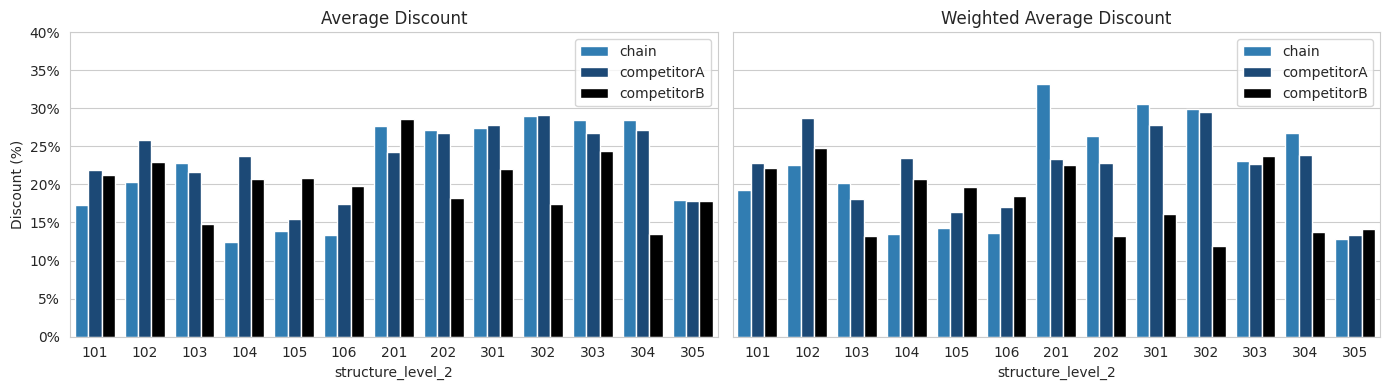

In [127]:
df_avg_discount = df.copy()
df_avg_discount['discount_qty_pf1'] = (df_avg_discount['discount']*df_avg_discount['quantity']*df_avg_discount['flag_promo'])
df_avg_discount['qty_pf1'] = (df_avg_discount['quantity']*df_avg_discount['flag_promo'])
df_avg_discount = df_avg_discount.loc[((df_avg_discount['flag_promo']==1))]

df_avg_discount = (df_avg_discount.groupby([column_to_group, 'competitor'])
                                          .agg({'discount_qty_pf1': "sum",
                                                'qty_pf1': "sum",
                                                'discount': "mean"}))
df_avg_discount['avg_discount_w'] = df_avg_discount['discount_qty_pf1']/df_avg_discount['qty_pf1']
df_avg_discount_plot = df_avg_discount.rename(columns={'discount':'avg_discount'})[['avg_discount', 'avg_discount_w']]

### PLOT
df_avg_discount_plot = df_avg_discount_plot.reset_index()
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
metrics = ['avg_discount', 'avg_discount_w']
titles = ['Average Discount', 'Weighted Average Discount']

custom_palette = {
    'chain': '#1c81c7',   # blue
    'competitorA': '#0d4985',   # darker blue
    'competitorB': '#000000'    # black
}

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        data=df_avg_discount_plot,
        x=column_to_group,
        y=metric,
        hue='competitor',
        errorbar=None,
        ax=ax,
        palette=custom_palette
    )
    
    # Format y-axis as %
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    
    # # Add % labels
    # for container in ax.containers:
    #     labels = [f'{v.get_height() * 100:.0f}%' for v in container]
    #     ax.bar_label(container, labels=labels, padding=3)
    
    # Titles and labels
    ax.set_title(titles[i])
    ax.set_xlabel(column_to_group)
    if i == 0:
        ax.set_ylabel('Discount (%)')
    else:
        ax.set_ylabel('')
    
    ax.set_ylim(0, 0.4)  # Adjust Y-axis range as needed
    ax.legend(title=None)

# Final layout
plt.tight_layout()
plt.show()

### Promo Participation

In [77]:
column_to_group = 'structure_level_2'

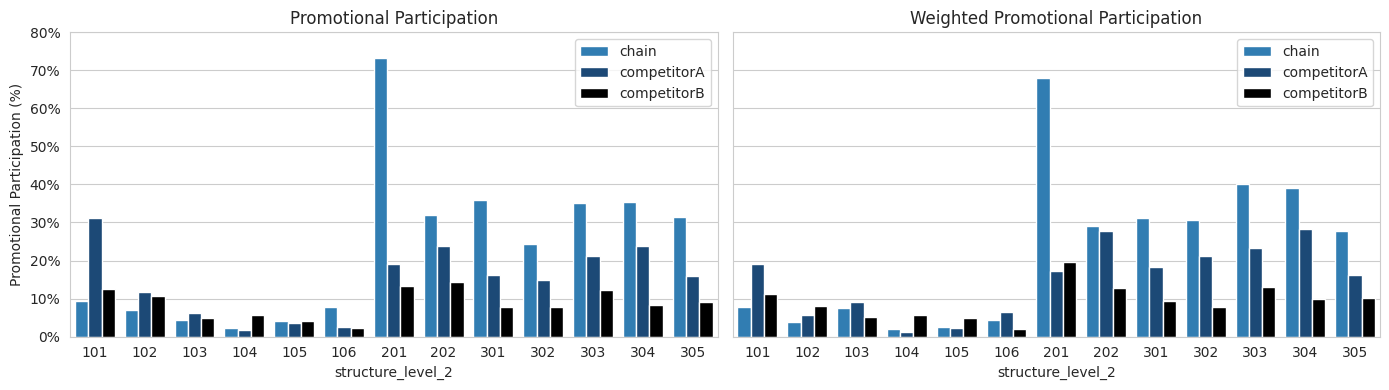

In [129]:
df_pp = df.copy()
df_pp['qty_pf1'] = (df_pp['quantity']*df_pp['flag_promo'])
df_pp = (df_pp.groupby([column_to_group, 'competitor'])
              .agg(qty_pf1 = ("qty_pf1","sum"),
                   quantity = ("quantity","sum"),
                   count_pf1 = ("flag_promo","sum"),
                   count_all = ("flag_promo","count")))
df_pp['promo_part_w'] = df_pp['qty_pf1']/df_pp['quantity']
df_pp['promo_part'] = df_pp['count_pf1']/df_pp['count_all']
df_pp_plot = df_pp[['promo_part_w', 'promo_part']]
df_pp_plot

### PLOT
df_pp_plot = df_pp_plot.reset_index()
# fig, axes = plt.subplots(1, 2, figsize=(12, 2.5), sharey=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
metrics = ['promo_part_w', 'promo_part']
titles = ['Promotional Participation', 'Weighted Promotional Participation']

custom_palette = {
    'chain': '#1c81c7',   # blue
    'competitorA': '#0d4985',   # darker blue
    'competitorB': '#000000'    # black
}

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        data=df_pp_plot,
        x=column_to_group,
        y=metric,
        hue='competitor',
        errorbar=None,
        palette=custom_palette,
        ax=ax
    )
    
    # Format y-axis as %
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    ax.set_ylim(0, 0.8)
    
    # Add % labels
    # for container in ax.containers:
    #     labels = [f'{v.get_height() * 100:.0f}%' for v in container]
    #     ax.bar_label(container, labels=labels, padding=3)
    
    # Titles and labels
    ax.set_title(titles[i])
    ax.set_xlabel(column_to_group)
    if i == 0:
        ax.set_ylabel('Promotional Participation (%)')
    else:
        ax.set_ylabel('')
    
    ax.legend(title=None)

# Final layout
plt.tight_layout()
plt.show()

### Price competitiveness

In [130]:
column_to_group = 'structure_level_2'

In [131]:
## detetar delta % de diferença de preço entre cada comp e o retailz 
## ponderar por vendas vs média simples
df_price_comp = df.copy()
pc_cols = ['structure_level_1','structure_level_2','structure_level_3','structure_level_4','sku','date','competitor', 'pvp_is', 'quantity']
df_price_comp = df_price_comp[pc_cols]
df_price_comp = df_price_comp.drop_duplicates()
df_price_comp = (df_price_comp.pivot(index=['structure_level_1','structure_level_2','structure_level_3','structure_level_4','sku','date', 'quantity'],
                                     columns='competitor',
                                     values='pvp_is'
                                    ))
df_price_comp = df_price_comp.reset_index()
df_price_comp.columns.name = None

# exclude rows with no competitors prices at all
df_price_comp = df_price_comp.loc[~(df_price_comp['competitorA'].isna() & df_price_comp['competitorB'].isna())]

## calculate difference price delta
df_price_comp['price_diff_cA'] = (df_price_comp['competitorA']-df_price_comp['chain'])/df_price_comp['chain']
df_price_comp['price_diff_cB'] = (df_price_comp['competitorB']-df_price_comp['chain'])/df_price_comp['chain']
df_price_comp['price_diff_cA_w'] = (df_price_comp['price_diff_cA']*df_price_comp['quantity'])
df_price_comp['price_diff_cB_w'] = (df_price_comp['price_diff_cB']*df_price_comp['quantity'])
df_price_comp[['price_diff_cA_w','price_diff_cB_w']] = df_price_comp[['price_diff_cA_w','price_diff_cB_w']].fillna(value=0)

## agregar
df_price_comp = (df_price_comp.groupby([column_to_group])
                              .agg(price_comp_A = ("price_diff_cA","mean"),
                                   price_comp_B = ("price_diff_cB","mean"),
                                   price_diff_cA_w = ("price_diff_cA_w","sum"),
                                   price_diff_cB_w = ("price_diff_cB_w","sum"),
                                  quantity = ("quantity","sum")))
df_price_comp['price_comp_A_w'] = df_price_comp['price_diff_cA_w']/df_price_comp['quantity']
df_price_comp['price_comp_B_w'] = df_price_comp['price_diff_cB_w']/df_price_comp['quantity']
df_price_comp_plot = df_price_comp[['price_comp_A', 'price_comp_B', 'price_comp_A_w','price_comp_B_w']]
df_price_comp_plot

## so esta a dar asneira pq as vezes tenho nan outras nao etc. e se eu substituir por 0 quando tenho NaN? -> ver se resultou

,price_comp_A,price_comp_B,price_comp_A_w,price_comp_B_w
structure_level_2,,,,
101,0.006711,-0.013541,0.004798,0.004162
102,-0.003640,-0.050714,0.019812,-0.001959
103,0.024849,-0.036773,0.018028,-0.022525
104,0.102424,-0.044709,0.078495,-0.020203
105,0.180560,0.000709,0.119394,-0.002687
106,0.096402,-0.024407,0.071301,-0.011978
201,0.024605,-0.005446,0.082840,0.014683
202,0.036884,-0.008012,0.039619,0.014257
301,0.056808,0.056191,0.095634,0.060793


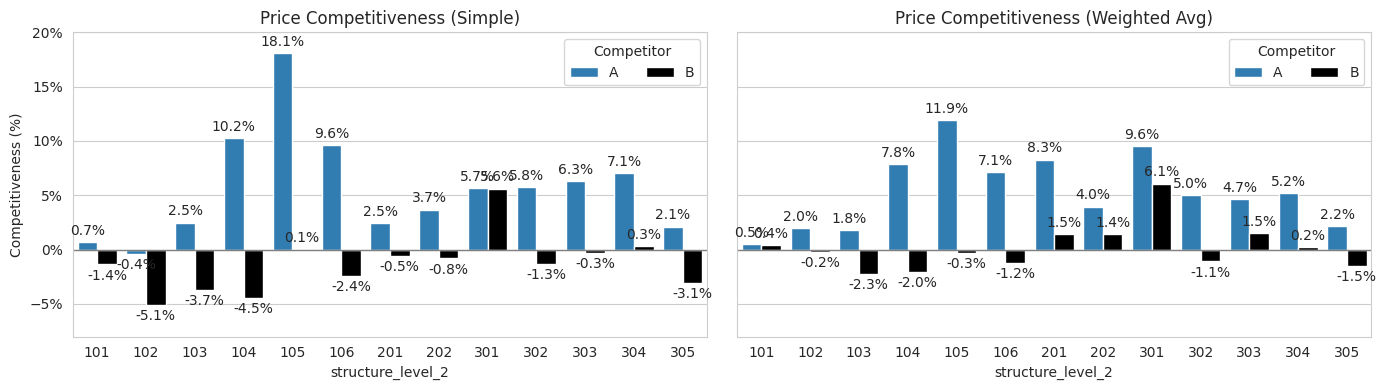

In [140]:
# Assume df is your original DataFrame with structure_level_1 as index
df_reset = df_price_comp_plot.reset_index()

# Create 1 row, 2 column subplot layout
# fig, axes = plt.subplots(1, 2, figsize=(12, 2.5), sharey=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Define metric sets and titles
metric_groups = [
    (['price_comp_A', 'price_comp_B'], 'Price Competitiveness (Simple)'),
    (['price_comp_A_w', 'price_comp_B_w'], 'Price Competitiveness (Weighted Avg)')
]

# Plot each group
for i, (metrics, title) in enumerate(metric_groups):
    # Melt data
    df_melted = df_reset.melt(
        id_vars=column_to_group,
        value_vars=metrics,
        var_name='metric',
        value_name='value'
    )
    
    # Extract competitor (A or B)
    df_melted['competitor'] = df_melted['metric'].str.extract(r'price_comp_(A|B)')
    custom_palette = {
    'A': '#1c81c7',   # blue
    'B': '#000000',   # black
    }
    # Plot
    ax = axes[i]
    sns.barplot(
        data=df_melted,
        x=column_to_group,
        y='value',
        hue='competitor',
        palette=custom_palette,
        ax=ax
    )
    
    # Add % labels on bars
    for container in ax.containers:
        labels = [f'{v.get_height()*100:.1f}%' for v in container]
        ax.bar_label(container, labels=labels, padding=3)
    
    # Formatting
    ax.set_title(title)
    ax.set_xlabel(column_to_group)
    if i == 0:
        ax.set_ylabel('Competitiveness (%)')
    else:
        ax.set_ylabel('')
    ax.set_ylim(-0.08, 0.20)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    ax.axhline(0, color='gray', linewidth=1)
    ax.legend(title='Competitor',ncol=len(df.columns))

plt.tight_layout()
plt.show()

### Reactive price behaviour

In [141]:
column_to_group = 'structure_level_1'

In [ ]:
## ok isto é complexo. no fundo preciso de detetar mudanças de preço. mas se tivermos 2.59 2.09 2.59 -> a semana do meio é a unica com alteração 
# pq dps voltámos ao preço normal. Ou seja pelo desconto conseguimos ver. MAs tb pode mudar o was. portanto precisamos de criar a colunas 
# pvp_was_corrected que terá o valor normal de pvp_was para que consigamos detetar mudanças tb no preço regular

## 1. ir buscar código em pyspark para calcular o pvp_was_corrected e pedir para replicar em pandas
## 2. ter coluna que deteta discount_was
## 3. pensar se quero que o discount tenha tanto as mudanças no was como as do is ou se quero análises separadas
## 4. depois de ter a coluna desconto quero usá-la 

In [45]:
df.loc[((df.sku==3579) & (df.time_key>=20240501) & (df.time_key<=20240601) & (df.competitor=='chain'))].sort_values(by=['sku', 'time_key'])

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,date,structure_level_4,structure_level_3,structure_level_2,structure_level_1,quantity,chain_campaign,pvp_is
597810,3579,20240501,chain,64.05,0.0,0,NaN,2024-05-01,1020701,10207,102,1,11454.5376,C1,64.05
3111325,3579,20240502,chain,64.05,0.0,0,NaN,2024-05-02,1020701,10207,102,1,9796.6440,C1,64.05
107114,3579,20240503,chain,64.05,0.0,0,NaN,2024-05-03,1020701,10207,102,1,10499.1624,C1,64.05
3108227,3579,20240504,chain,64.05,0.0,0,NaN,2024-05-04,1020701,10207,102,1,15755.5944,C1,64.05
764873,3579,20240505,chain,64.05,0.0,0,NaN,2024-05-05,1020701,10207,102,1,10056.9744,C1,64.05
1806398,3579,20240506,chain,64.05,0.0,0,NaN,2024-05-06,1020701,10207,102,1,8428.9752,C1,64.05
927774,3579,20240507,chain,48.43,0.0,0,weekly,2024-05-07,1020701,10207,102,1,9599.8392,C1,48.43
2137150,3579,20240508,chain,48.43,0.0,0,weekly,2024-05-08,1020701,10207,102,1,10962.5256,C1,48.43
2023245,3579,20240509,chain,48.43,0.0,0,weekly,2024-05-09,1020701,10207,102,1,9907.5024,C1,48.43
787748,3579,20240510,chain,48.43,0.0,0,weekly,2024-05-10,1020701,10207,102,1,12153.3192,C1,48.43


In [144]:
df_react = df.copy()

# df_react = df_react.pivot_table(
#     index=['structure_level_1','structure_level_2','structure_level_3','structure_level_4','sku','time_key','date', 'quantity'],
#     columns='competitor',
#     values=['pvp_was', 'pvp_is'],
#     aggfunc='mean'  # in case there are duplicates
# ).sort_index()


# df_react = df_react.reset_index()

# df_react.columns = [
#     col[0] if isinstance(col, tuple) and col[1] == '' else f'{col[0]}_{col[1]}'
#     for col in df_react.columns
# ]

In [145]:
(df_react.loc[((df_react.sku==3579) 
               & (df_react.time_key>=20240501) 
               & (df_react.time_key<=20240601))].sort_values(by=['sku', 'time_key']))

,sku,time_key,competitor,pvp_was,discount,flag_promo,leaflet,date,structure_level_4,structure_level_3,structure_level_2,structure_level_1,quantity,chain_campaign,pvp_is
597810,3579,20240501,chain,64.05,0.0,0,NaN,2024-05-01,1020701,10207,102,1,11454.5376,C1,64.05
771284,3579,20240501,competitorB,62.31,0.0,0,NaN,2024-05-01,1020701,10207,102,1,11454.5376,NaN,62.31
1597052,3579,20240501,competitorA,64.05,0.0,0,NaN,2024-05-01,1020701,10207,102,1,11454.5376,NaN,64.05
1482337,3579,20240502,competitorA,64.05,0.0,0,NaN,2024-05-02,1020701,10207,102,1,9796.6440,NaN,64.05
2269320,3579,20240502,competitorB,62.31,0.0,0,NaN,2024-05-02,1020701,10207,102,1,9796.6440,NaN,62.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502171,3579,20240531,competitorB,62.31,0.0,0,NaN,2024-05-31,1020701,10207,102,1,9421.7184,NaN,62.31
2940961,3579,20240531,chain,65.78,0.0,0,NaN,2024-05-31,1020701,10207,102,1,9421.7184,C2,65.78
477261,3579,20240601,chain,65.78,0.0,0,NaN,2024-06-01,1020701,10207,102,1,11570.3784,C2,65.78
2188024,3579,20240601,competitorB,62.31,0.0,0,NaN,2024-06-01,1020701,10207,102,1,11570.3784,NaN,62.31


In [105]:


# # ## Adicionar coluna pvp_was_corrected -> used to detect changes in regular price
# df_react = (df_react.sort_values(by=['sku', 'time_key']))
# df_react['count_pvp_was_chain_sku'] = (df_react.groupby(['sku', 'pvp_was_chain'])['pvp_was_chain']
#                                            .transform(lambda x: x.rolling(window=7*6, min_periods=1).count()))
# df_react['valid_pvp_was_chain'] = df_react['pvp_was_chain'].where(df_react['count_pvp_was_chain_sku'] >= 2)
# df_react['max_pvp_was_chain'] = (
#     df_react.groupby('sku')['valid_pvp_was_chain']
#     .transform(lambda x: x.rolling(window=7, min_periods=1).max())
#     .fillna(0)  # Fillna to mimic .fillna(0, ['max_was_price'])
# )
# df_react['pvp_was_chain_lead1'] = df_react.groupby('sku')['pvp_was_chain'].shift(-1)
# df_react['pvp_was_chain_lead2'] = df_react.groupby('sku')['pvp_was_chain_lead1'].shift(-1)
# df_react = df_react.rename(columns={'pvp_was_chain': 'old_pvp_was_chain'})
# df_react['pvp_was_chain'] = np.where(
#     df_react['old_pvp_was_chain'] >= df_react['max_pvp_was_chain'],
#     df_react['old_pvp_was_chain'],
#     np.where(
#         (df_react['old_pvp_was_chain'] == df_react['pvp_was_chain_lead1']) &
#         (df_react['old_pvp_was_chain'] == df_react['pvp_was_chain_lead2']),
#         df_react['old_pvp_was_chain'],
#         df_react['max_pvp_was_chain']
#     )
# )

In [74]:
(df_react.loc[((df_react.sku==3579) 
               & (df_react.time_key>=20240501) 
               & (df_react.time_key<=20240601))].sort_values(by=['sku', 'time_key']))

,structure_level_1,structure_level_2,structure_level_3,structure_level_4,sku,time_key,date,quantity,pvp_is_chain,pvp_is_competitorA,pvp_is_competitorB,old_pvp_was_chain,pvp_was_competitorA,pvp_was_competitorB,count_pvp_was_chain_sku,valid_pvp_was_chain,max_pvp_was_chain,pvp_was_chain_lead1,pvp_was_chain_lead2,pvp_was_chain
114380,1,102,10207,1020701,3579,20240501,2024-05-01,11454.5376,64.05,64.05,62.310000,64.05,64.05,62.31,7.0,64.05,64.05,64.05,64.05,64.05
114381,1,102,10207,1020701,3579,20240502,2024-05-02,9796.6440,64.05,64.05,62.310000,64.05,64.05,62.31,7.0,64.05,64.05,64.05,64.05,64.05
114382,1,102,10207,1020701,3579,20240503,2024-05-03,10499.1624,64.05,64.05,62.310000,64.05,64.05,62.31,7.0,64.05,64.05,64.05,64.05,64.05
114383,1,102,10207,1020701,3579,20240504,2024-05-04,15755.5944,64.05,64.05,62.310000,64.05,64.05,62.31,7.0,64.05,64.05,64.05,64.05,64.05
114384,1,102,10207,1020701,3579,20240505,2024-05-05,10056.9744,64.05,64.05,62.310000,64.05,64.05,62.31,7.0,64.05,64.05,64.05,48.43,64.05
114385,1,102,10207,1020701,3579,20240506,2024-05-06,8428.9752,64.05,64.05,62.310000,64.05,64.05,62.31,7.0,64.05,64.05,48.43,48.43,64.05
114386,1,102,10207,1020701,3579,20240507,2024-05-07,9599.8392,48.43,64.05,62.310000,48.43,64.05,62.31,1.0,NaN,64.05,48.43,48.43,48.43
114387,1,102,10207,1020701,3579,20240508,2024-05-08,10962.5256,48.43,64.05,62.310000,48.43,64.05,62.31,2.0,48.43,64.05,48.43,48.43,48.43
114388,1,102,10207,1020701,3579,20240509,2024-05-09,9907.5024,48.43,64.05,62.310000,48.43,64.05,62.31,3.0,48.43,64.05,48.43,48.43,48.43
114389,1,102,10207,1020701,3579,20240510,2024-05-10,12153.3192,48.43,64.05,62.310000,48.43,64.05,62.31,4.0,48.43,64.05,48.43,48.43,48.43


In [146]:

# df_react['pvp_was_corrected'] 


pc_cols = ['structure_level_1','structure_level_2','structure_level_3','structure_level_4','sku','date','competitor', 'discount', 'quantity']
df_react = df_react[pc_cols]
df_react = df_react.drop_duplicates()

# df_react = df_react.pivot_table(
#     index=['structure_level_1','structure_level_2','structure_level_3','structure_level_4','sku','date', 'quantity'],
#     columns='competitor',
#     values='pvp_is',
#     aggfunc='mean'  # in case there are duplicates
# ).sort_index()

In [147]:
df_react.loc[((df_react.sku==4435))]

,structure_level_1,structure_level_2,structure_level_3,structure_level_4,sku,date,competitor,discount,quantity
1,3,303,30307,3030708,4435,2023-06-21,chain,0.2754,198.0504
494,3,303,30307,3030708,4435,2024-08-25,chain,0.1680,87.1920
4608,3,303,30307,3030708,4435,2023-12-04,competitorA,0.1834,130.7880
4727,3,303,30307,3030708,4435,2024-07-24,chain,0.0920,359.9784
9950,3,303,30307,3030708,4435,2023-12-05,chain,0.0000,154.4544
...,...,...,...,...,...,...,...,...,...
3107965,3,303,30307,3030708,4435,2024-03-05,chain,0.1834,220.4712
3112228,3,303,30307,3030708,4435,2023-01-22,competitorA,0.0000,398.5920
3113449,3,303,30307,3030708,4435,2023-06-08,competitorA,0.0000,125.8056
3116549,3,303,30307,3030708,4435,2023-01-24,competitorA,0.2754,80.9640


In [46]:


# for comp in df_react.columns:
#     df_react[f'{comp}_change'] = df_react[comp] != df_react[comp].shift()

# # Reset index so we can group by SKU
# df_react = df_react.reset_index()

# # Create a helper column to make reactions easier to detect
# def get_reactions(group, leader='chain', follower='competitorA', lag_days=7):
#     reactions = []
#     group = group.sort_values('date')
#     for idx, row in group.iterrows():
#         if row[f'{leader}_change']:
#             leader_date = row['date']
#             # Look ahead for price change by follower
#             mask = (
#                 (group['date'] > leader_date) &
#                 (group['date'] <= leader_date + pd.Timedelta(days=lag_days)) &
#                 (group[f'{follower}_change'])
#             )
#             if mask.any():
#                 reactions.append((leader_date, follower))
#     return reactions

# # Apply per SKU
# all_reactions = []

# for sku, group in df_react.groupby('sku'):
#     reactions_A = get_reactions(group, 'chain', 'competitorA')
#     reactions_B = get_reactions(group, 'chain', 'competitorB')
#     all_reactions.extend([(sku, d, f) for d, f in reactions_A + reactions_B])

In [44]:
df_reactions = pd.DataFrame(all_reactions, columns=['sku', 'reaction_date', 'follower'])

# Count reactions
reaction_summary = df_reactions.groupby('follower').size().reset_index(name='reaction_count')
print(reaction_summary)

      follower  reaction_count
0  competitorA           65706
1  competitorB          100702


In [48]:
df_react.loc[((df_react.sku==2659))]

competitor,structure_level_1,structure_level_2,structure_level_3,structure_level_4,sku,date,quantity,chain,competitorA,competitorB,chain_change,competitorA_change,competitorB_change
163708,1,103,10304,1030416,2659,2023-01-03,521.9064,51.9,51.9,51.90,True,True,True
163709,1,103,10304,1030416,2659,2023-01-04,549.3096,51.9,51.9,51.90,False,False,False
163710,1,103,10304,1030416,2659,2023-01-05,591.6600,51.9,51.9,51.90,False,False,False
163711,1,103,10304,1030416,2659,2023-01-06,630.2736,51.9,51.9,51.90,False,False,False
163712,1,103,10304,1030416,2659,2023-01-07,701.2728,51.9,51.9,51.90,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164296,1,103,10304,1030416,2659,2024-08-14,843.2712,51.9,51.9,48.43,False,False,False
164297,1,103,10304,1030416,2659,2024-08-15,909.2880,51.9,51.9,48.43,False,False,False
164298,1,103,10304,1030416,2659,2024-08-26,832.0608,51.9,NaN,48.43,False,True,False
164299,1,103,10304,1030416,2659,2024-08-27,851.9904,51.9,NaN,48.43,False,True,False


In [40]:
df_react.loc[((df_react.sku==4435) | (df_react.sku==2659))]

,sku,date,competitor,pvp_is,quantity
1,4435,2023-06-21,chain,13.709432,198.0504
494,4435,2024-08-25,chain,17.180800,87.1920
3717,2659,2024-05-15,chain,51.900000,756.0792
4608,4435,2023-12-04,competitorA,15.450072,130.7880
4727,4435,2024-07-24,chain,17.179360,359.9784
...,...,...,...,...,...
3116549,4435,2023-01-24,competitorA,13.709432,80.9640
3116685,2659,2024-07-15,competitorB,46.690000,1108.5840
3116830,4435,2024-01-14,competitorA,15.450072,123.3144
3116846,2659,2024-06-28,chain,51.900000,893.0952


## Others

### Outliers

### Data distribution

<Axes: xlabel='Health Service Area', ylabel='count'>

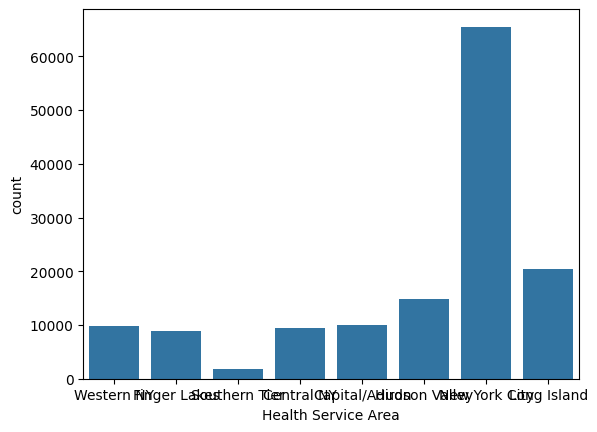

In [9]:

# Checking distribution of Health Service Area
sns.countplot(x = df_train['Health Service Area'])

<Axes: xlabel='Gender', ylabel='count'>

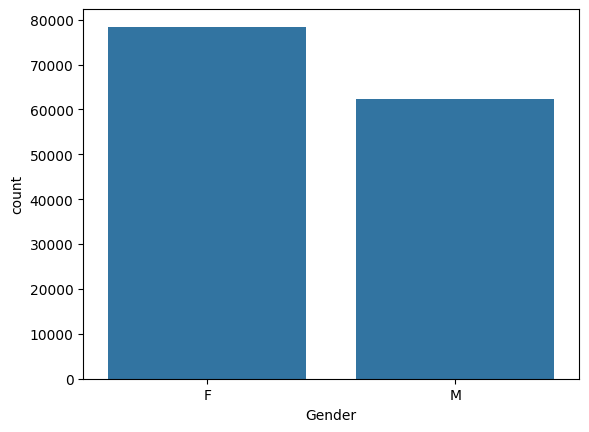

In [10]:
# Checking distribution of Gender
sns.countplot(x = df_train['Gender'])

<Axes: xlabel='Emergency Department Indicator', ylabel='count'>

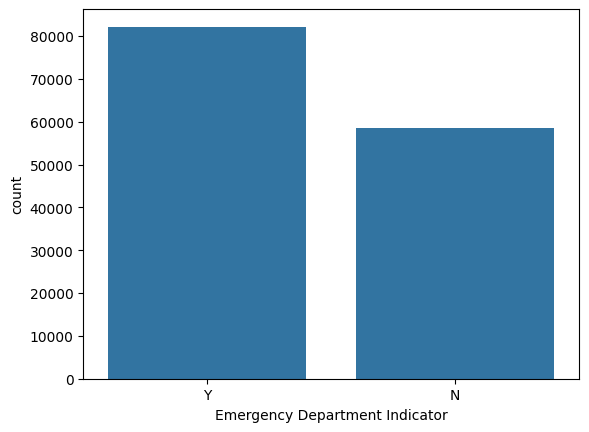

In [11]:


# Checking distribution of Emergency Department Indicator
sns.countplot(x = df_train['Emergency Department Indicator'])


<Axes: xlabel='Patient Disposition', ylabel='count'>

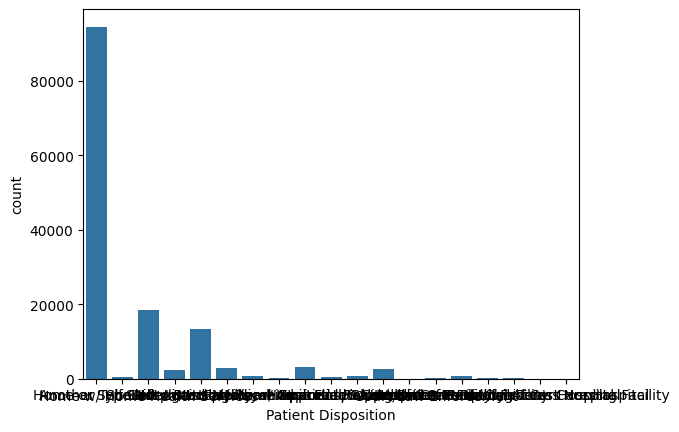

In [12]:
# Checking distribution of Patient Disposition
sns.countplot(x = df_train['Patient Disposition'])



<Axes: xlabel='APR Medical Surgical Description', ylabel='count'>

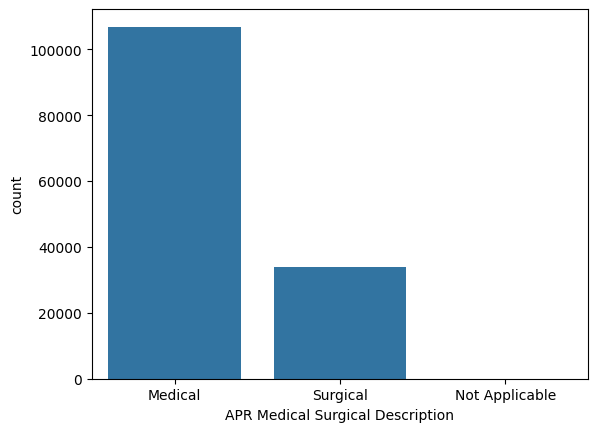

In [13]:

# Checking distribution of 'APR Medical Surgical Description'
sns.countplot(x = df_train['APR Medical Surgical Description'])

<Axes: xlabel='Birth Weight', ylabel='count'>

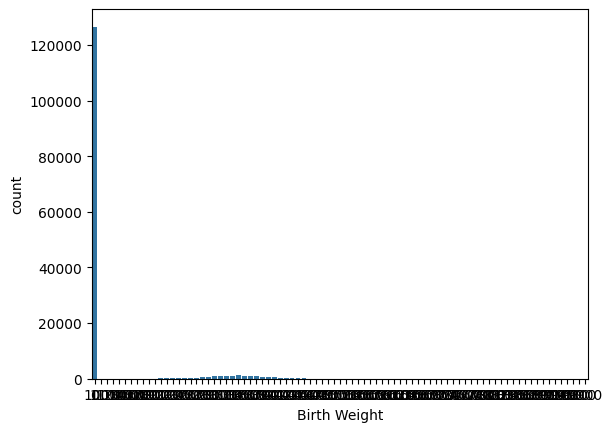

In [14]:
# Checking distribution of Birth Weight
sns.countplot(x = df_train['Birth Weight'])

In [80]:
# Identify columns with fewer than 2 unique values
few_unique_columns = df_train.nunique()
columns_less_than_2 = few_unique_columns[few_unique_columns < 3]

# Create a DataFrame for visualization
columns_summary = pd.DataFrame({
    'Column Name': columns_less_than_2.index,
    'Unique Values': columns_less_than_2.values
})
print(columns_summary)

                      Column Name  Unique Values
0                          Gender              2
1                  Discharge Year              1
2         Abortion Edit Indicator              2
3  Emergency Department Indicator              2


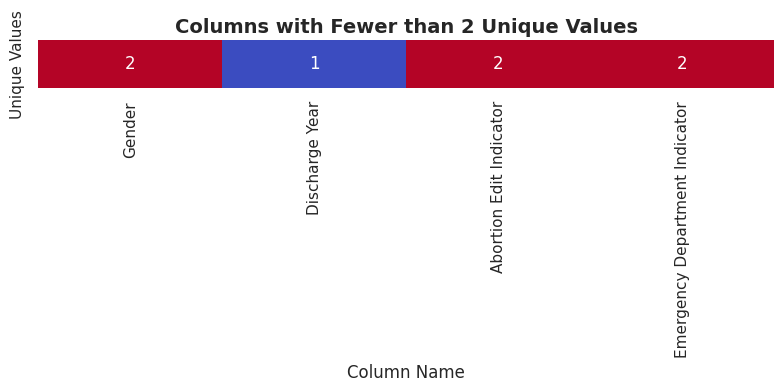

In [81]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    columns_summary.set_index('Column Name').T,
    annot=True,
    fmt=".0f",
    cmap="coolwarm",
    cbar=False
)

# Aesthetic adjustments
plt.title("Columns with Fewer than 2 Unique Values", fontsize=14, fontweight="bold")
plt.xlabel("Column Name", fontsize=12)
plt.tight_layout()
plt.show()

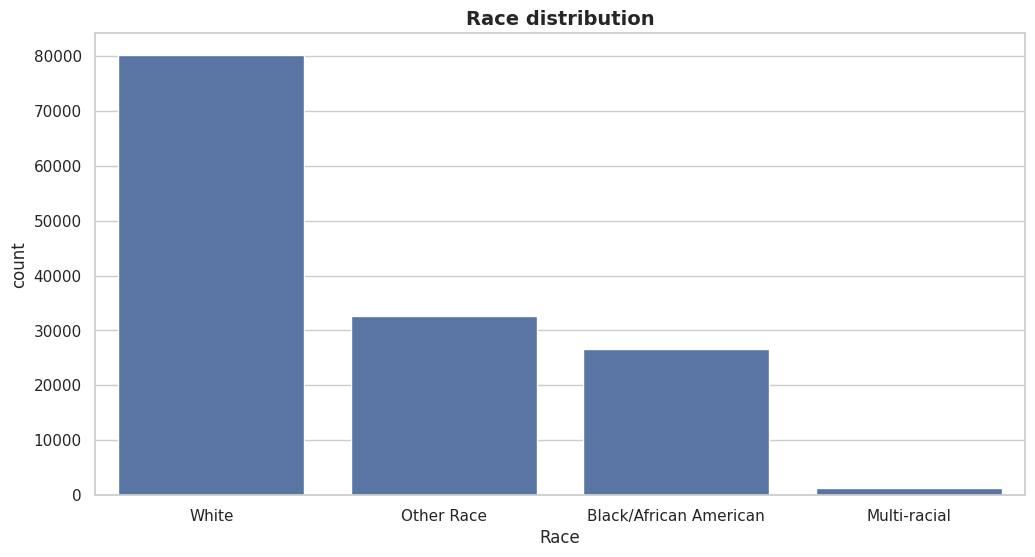

In [74]:
# Checking distribution of RACE
plt.figure(figsize=(12, 6))
sns.countplot(x = df_train['Race'])

# Enhance plot aesthetics
plt.title("Race distribution", fontsize=14, fontweight="bold")

plt.show()

<Axes: xlabel='Ethnicity', ylabel='count'>

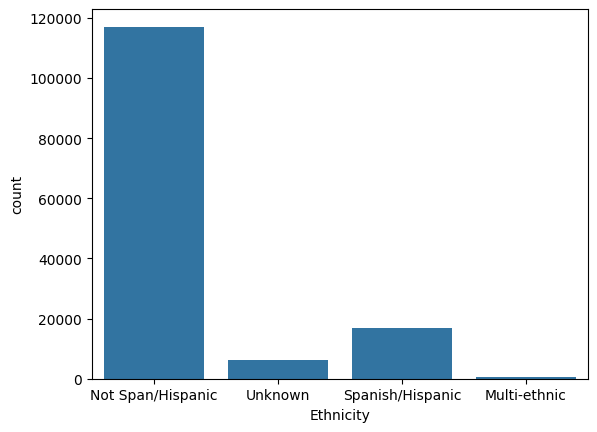

In [17]:
# Checking distribution of Ethnicity
sns.countplot(x = df_train['Ethnicity'])

In [18]:
# Nº unique values per columns
df_train.nunique()

observation_id                         140805
Health Service Area                         8
Hospital County                            57
Operating Certificate Number              178
Facility Id                               212
Facility Name                             214
Age Group                                   5
Zip Code - 3 digits                        50
Gender                                      2
Race                                        4
Ethnicity                                   4
Length of Stay                            119
Type of Admission                           6
Patient Disposition                        19
Discharge Year                              1
CCS Diagnosis Code                        261
CCS Diagnosis Description                 261
CCS Procedure Code                        226
CCS Procedure Description                 226
APR DRG Code                              316
APR DRG Description                       316
APR MDC Code                      

In [68]:
df_train['Length of Stay'].max()

120

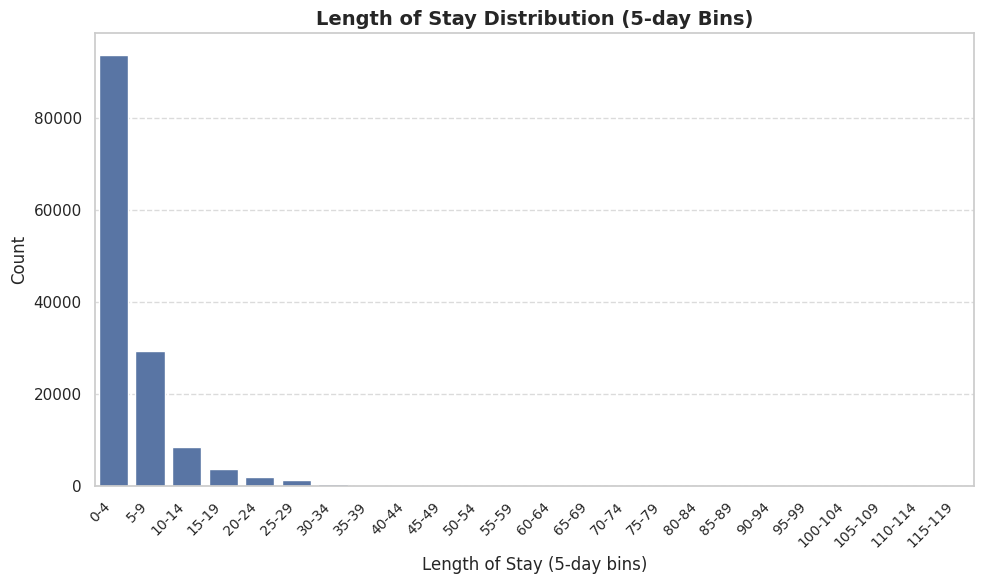

In [71]:
# Create bins with 5-day intervals
bins = range(0, df_train['Length of Stay'].max() + 5, 5)  # Adjust the range based on your data
labels = [f"{i}-{i+4}" for i in bins[:-1]]  # Generate labels like "0-4", "5-9", etc.
df_train['Length of Stay (5-day bins)'] = pd.cut(df_train['Length of Stay'], bins=bins, labels=labels, right=False)

# Plot the binned data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x="Length of Stay (5-day bins)")

# Enhance plot aesthetics
plt.title("Length of Stay Distribution (5-day Bins)", fontsize=14, fontweight="bold")
plt.xlabel("Length of Stay (5-day bins)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
 df_train['Length of Stay'].max()

120

In [21]:
 df_train['Length of Stay'].max()

120

<Axes: xlabel='Facility Name', ylabel='count'>

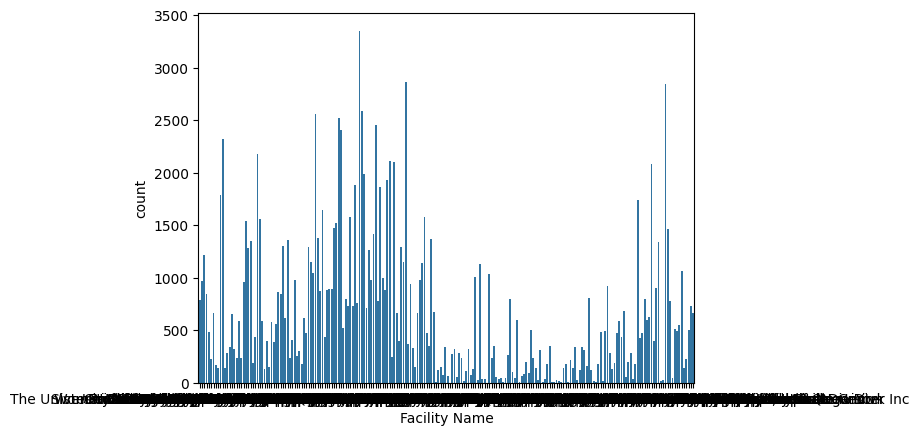

In [22]:
# Checking distribution of Facility Name
sns.countplot(x = df_train['Facility Name'])

<Axes: xlabel='CCS Diagnosis Description', ylabel='count'>

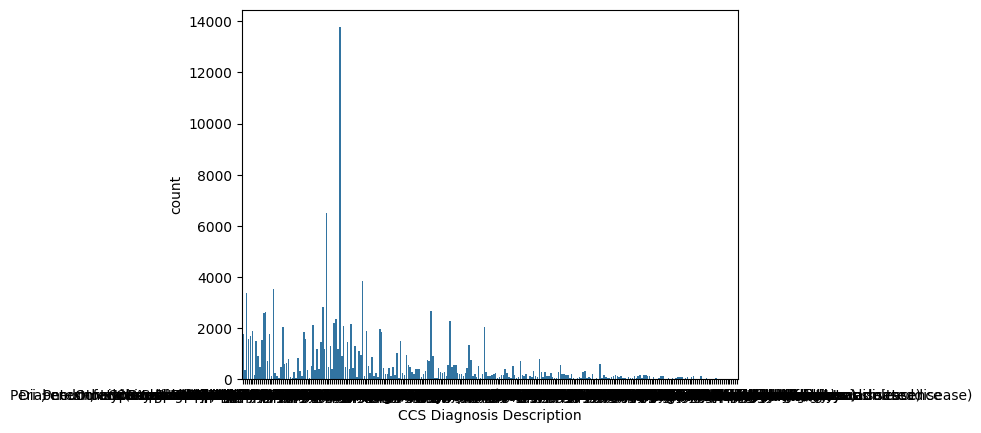

In [23]:
# Checking distribution of CCS Diagnosis Description
sns.countplot(x = df_train['CCS Diagnosis Description'])

<Axes: xlabel='CCS Procedure Description', ylabel='count'>

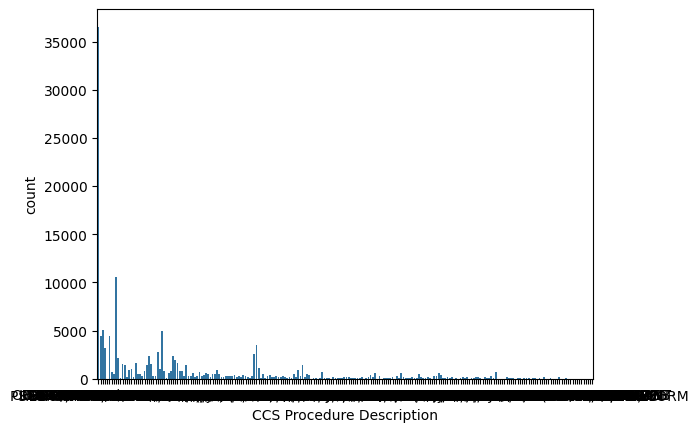

In [24]:
# Checking distribution of CCS Procedure Description
sns.countplot(x = df_train['CCS Procedure Description'])

In [25]:
# Checking distribution of CCS Procedure Description
df_train['CCS Procedure Description'].value_counts()

CCS Procedure Description
NO PROC                    36536
OTHER THERAPEUTIC PRCS     10558
OT PRCS TO ASSIST DELIV     5089
PROPHYLACTIC VAC/INOCUL     4973
RESP INTUB/MECH VENTIL      4434
                           ...  
BUNIONECTOMY/TOE DEFORM        2
MICRO EX (BACT SMEAR)          2
CORNEAL TRANSPLANT             1
INJ/LIG ESOPH VARICES          1
DX AMNIOCENTESIS               1
Name: count, Length: 226, dtype: int64

In [26]:
# Checking distribution of CCS DRG Description
df_train['APR DRG Description'].value_counts()

APR DRG Description
Neonate birthwt >2499g, normal newborn or neonate w other problem    11999
Vaginal delivery                                                      8918
Septicemia & disseminated infections                                  5720
Cesarean delivery                                                     4492
Heart failure                                                         3405
                                                                     ...  
Extensive 3rd degree burns w skin graft                                  5
Neonate w ECMO                                                           3
Neonate, transferred <5 days old, not born here                          2
Pancreas transplant                                                      2
Ungroupable                                                              1
Name: count, Length: 316, dtype: int64

### Correlation Matrix

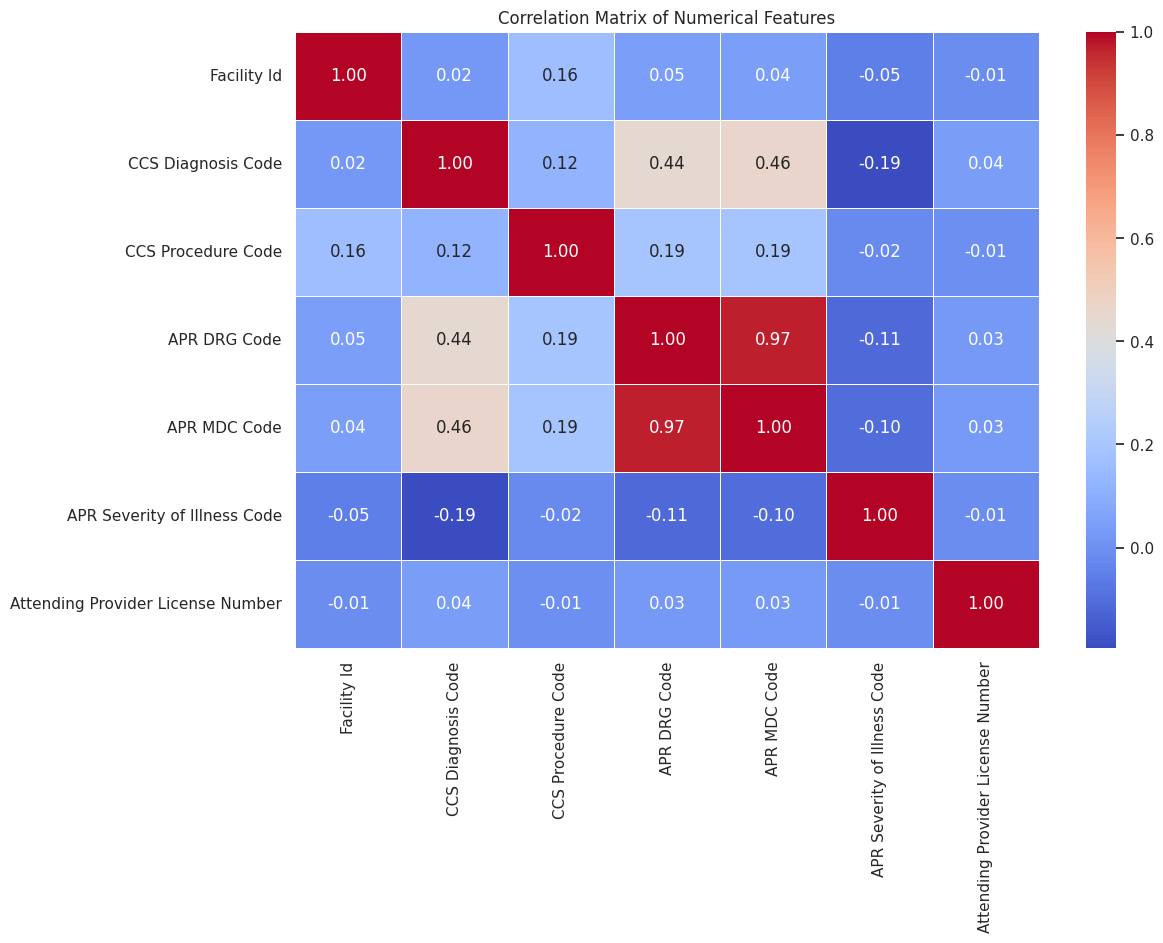

In [86]:
numerical_features = ['Facility Id', 'CCS Diagnosis Code', 'CCS Procedure Code', 'APR DRG Code', 
                      'APR MDC Code', 'APR Severity of Illness Code', 'Attending Provider License Number']

# Compute the correlation matrix
correlation_matrix = X_train[numerical_features].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [84]:

# Compute the correlation matrix for numerical columns
correlation_matrix = df_train.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add titles and labels
plt.title("Correlation Matrix of Numerical Features", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'cdb7f86a-68c8-4a11-a54a-d6ab74fdb7fe'

Remover colunas que trazem LIKAGE

In [27]:
# df_train_filter = df_train.drop(['Total Costs','Total Charges'], axis=1)

## Filtered dataset

In [28]:
len(df_train)

140805

In [104]:
len(df_train.drop('Length of Stay', axis=1).columns)

39

In [102]:
len(features_we_want)

14

In [85]:
# df_train['Payment'] = np.where(
#     (df_train['Payment Typology 1'] == 'Self-Pay') |
#     (df_train['Payment Typology 2'] == 'Self-Pay') |
#     (df_train['Payment Typology 3'] == 'Self-Pay'),
#     'Self-Pay',
#     'Other'
# )

features_we_want  = ['Facility Id', 'Age Group', 'Race', 'Type of Admission', 
                  'CCS Diagnosis Code', 'CCS Procedure Code', 'APR DRG Code', 'APR MDC Code', 'APR Severity of Illness Code', 'APR Risk of Mortality',
                   'Attending Provider License Number', #'Payment', 
                    'Emergency Department Indicator',
                   'Gender', 'Health Service Area'
                    ]
target = ['Length of Stay']

df_train_filter = df_train[features_we_want + target]

# df_train_filter["Diagnosis Proc Interaction"] = df_train_filter["CCS Diagnosis Code"].astype(str) + "_" + df_train_filter["CCS Procedure Code"].astype(str)
# df_train_filter.drop(columns=["CCS Diagnosis Code", "CCS Procedure Code"], inplace=True)

### Remove null data for Facility Id (183 rows)
df_train_filter =df_train_filter.dropna(how='any',axis=0) 

X_train, y_train = df_train_filter.drop(target, axis=1), df_train_filter[target]

X_train.head()

,Facility Id,Age Group,Race,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,Attending Provider License Number,Emergency Department Indicator,Gender,Health Service Area
0,208.0,0 to 17,White,Emergency,128,0,141,4,2,Minor,270457.0,Y,F,Western NY
1,208.0,0 to 17,White,Emergency,138,0,243,6,1,Minor,244296.0,Y,M,Western NY
2,210.0,0 to 17,Other Race,Emergency,657,0,754,19,2,Minor,239618.0,Y,F,Western NY
3,213.0,18 to 29,White,Emergency,83,0,53,1,2,Moderate,210044.0,Y,F,Western NY
4,213.0,18 to 29,Other Race,Elective,189,134,540,14,1,Minor,229449.0,N,F,Western NY


In [30]:
len(df_train_filter)

140615

### Pipeline

In [93]:
categorical_ordinal = ['APR Risk of Mortality']
# categorical_features = ['Age Group','Race', 'Ethnicity', 'Type of Admission', 'APR Risk of Mortality']
# categorical_features = ['Age Group','Race', 'Ethnicity', 'Type of Admission']
categorical_features = ['Age Group','Race', 'Type of Admission', #'Payment', 
                        'Emergency Department Indicator', 
                        'Gender', 
                        'Health Service Area'
                       ]
numerical_features = ['Facility Id', 'CCS Diagnosis Code', 'CCS Procedure Code', 'APR DRG Code', 'APR MDC Code', 'APR Severity of Illness Code'
                      ,
                     'Attending Provider License Number'
                     ]
sensitive_feature = "Race"  # The sensitive attribute
# numerical_features = ['Facility Id', 'Diagnosis Proc Interaction', 'APR DRG Code', 'APR MDC Code', 'APR Severity of Illness Code']

severity_mapping = [['Minor', 'Moderate', 'Major', 'Extreme']]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
categorical_transformer_ord = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=severity_mapping))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('cat_ord', categorical_transformer_ord, categorical_ordinal)
    ])
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # Apply SMOTE
#     ('model', XGBRegressor(
#     n_estimators=500,      # Number of boosting rounds (trees)
#     learning_rate=0.05,    # Step size shrinkage (lower = better generalization)
#     max_depth=6,           # Max depth of each tree (controls complexity)
#     subsample=0.8,         # Fraction of samples used per tree (helps prevent overfitting)
#     colsample_bytree=0.8,  # Fraction of features used per tree (reduces correlation)
#     reg_alpha=0.1,         # L1 regularization (helps with feature selection)
#     reg_lambda=0.5,        # L2 regularization (prevents overfitting)
#     random_state=42))
# ])
# pipeline = ImbPipeline(steps=[
#     ('preprocessor', preprocessor),  # Step 1: Preprocess data
#     # ('smote', #SMOTE(sampling_strategy='auto', random_state=42)
#     #           SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=2)),  # Step 2: Apply SMOTE
#     ('model', XGBRegressor(
#     n_estimators=500,      # Number of boosting rounds (trees)
#     learning_rate=0.05,    # Step size shrinkage (lower = better generalization)
#     max_depth=6,           # Max depth of each tree (controls complexity)
#     subsample=0.8,         # Fraction of samples used per tree (helps prevent overfitting)
#     colsample_bytree=0.8,  # Fraction of features used per tree (reduces correlation)
#     reg_alpha=0.1,         # L1 regularization (helps with feature selection)
#     reg_lambda=0.5,        # L2 regularization (prevents overfitting)
#     random_state=42))
# ])
pipeline = make_pipeline(
    preprocessor,
    # SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=2),
    #("sample_weight", SampleWeightTransformer(sensitive_column=sensitive_feature)),  # Custom Weighting
    LinearRegression(),
    # LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    # XGBRegressor(
    # random_state=42)
    # XGBRegressor(
    # n_estimators=500,      # Number of boosting rounds (trees)
    # learning_rate=0.05,    # Step size shrinkage (lower = better generalization)
    # max_depth=6,           # Max depth of each tree (controls complexity)
    # subsample=0.8,         # Fraction of samples used per tree (helps prevent overfitting)
    # colsample_bytree=0.8,  # Fraction of features used per tree (reduces correlation)
    # reg_alpha=0.1,         # L1 regularization (helps with feature selection)
    # reg_lambda=0.5,        # L2 regularization (prevents overfitting)
    # random_state=42)

    # XGBRegressor(
    # n_estimators=300,      # Number of boosting rounds (trees)
    # learning_rate=0.1,    # Step size shrinkage (lower = better generalization)
    # max_depth=4,           # Max depth of each tree (controls complexity)
    # min_child_weight=1,
    # subsample=0.8,         # Fraction of samples used per tree (helps prevent overfitting)
    # colsample_bytree=0.8,  # Fraction of features used per tree (reduces correlation)
    # reg_alpha=0.1,         # L1 regularization (helps with feature selection)
    # reg_lambda=0.3,        # L2 regularization (prevents overfitting)
    # gamma=5,
    # random_state=42)

)
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ("smote", SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=2)),  # SMOTE step
#     ("model", XGBRegressor(
#         n_estimators=500,
#         learning_rate=0.05,
#         max_depth=6,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_alpha=0.1,
#         reg_lambda=0.5,
#         random_state=42
#     ))
# ])


# X_train_encoded = preprocessor.fit_transform(X_train_filtered)
# smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=1)
# X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train_filtered)

# pipeline.fit(X_train_res, y_train_res)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Facility Id',
                                                   'CCS Diagnosis Code',
                                                   'CCS Procedure Code',
                                                   'APR DRG Code',
                                                   'APR MDC Code',
                                                   'APR Severity of Illness '
                                                   'Code',
                                                   'Attending Provider License '
                                                   'Number']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='const...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age Group', 'Race',
                                                   'Type of Admission',
                                                   'Emergency Department '
                                                   'Indicator',
                                                   'Gender',
                                                   'Health Service Area']),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Minor',
                                                                                               'Moderate',
                                                                                               'Major',
                                                                                               'Extreme']]))]),
                                                  ['APR Risk of Mortality'])])),
                ('linearregression', LinearRegression())])

In [60]:
print(y_train.value_counts())

Length of Stay
2                 32797
3                 25613
1                 20086
4                 14962
5                  9526
                  ...  
106                   2
105                   2
114                   1
116                   1
111                   1
Name: count, Length: 119, dtype: int64


#### Hyperparameter tunning

In [24]:
### LIGHT GBM
# param_dist = {
#     'lgbmregressor__n_estimators': [100, 300, 500, 700],
#     'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'lgbmregressor__max_depth': [-1, 4, 6, 8, 10],  
#     'lgbmregressor__num_leaves': [20, 31, 40, 50],  
#     'lgbmregressor__subsample': [0.6, 0.8, 1.0],  
#     'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],  
#     'lgbmregressor__reg_alpha': [0.0, 0.1, 0.2],  
#     'lgbmregressor__reg_lambda': [0.1, 0.2, 0.3],  
#     'lgbmregressor__min_child_samples': [10, 20, 30],  
#     'lgbmregressor__boosting_type': ['gbdt', 'dart'],  
# }
# param_dist = {
#     'lgbmregressor__n_estimators': [100, 300, 500],
#     'lgbmregressor__learning_rate': [0.01, 0.05, 0.1],
#     'lgbmregressor__max_depth': [4, 6, 8],  
#     'lgbmregressor__num_leaves': [20, 31, 40],  
# }
# random_search = RandomizedSearchCV(
#     pipeline, 
#     param_distributions=param_dist, 
#     n_iter=5,  
#     scoring='neg_mean_squared_error',  
#     cv=3,  
#     verbose=2,  
#     n_jobs=-1,  
#     random_state=42
# )

# random_search.fit(X_train, y_train)
# print("Best parameters found: ", random_search.best_params_)
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_test)


### XGB 
param_dist = {
    'xgbregressor__n_estimators': [100, 200, 300, 500],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 6, 8, 10],
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0.0, 0.1, 0.2],
    'xgbregressor__reg_lambda': [0.1, 0.2, 0.3, 0.5],
    # 'xgbregressor__gamma': [0, 1, 2, 5],
    # 'xgbregressor__min_child_weight': [1, 2, 3]
}
# XGBRegressor(
#     n_estimators=500,      # Number of boosting rounds (trees)
#     learning_rate=0.05,    # Step size shrinkage (lower = better generalization)
#     max_depth=6,           # Max depth of each tree (controls complexity)
#     subsample=0.8,         # Fraction of samples used per tree (helps prevent overfitting)
#     colsample_bytree=0.8,  # Fraction of features used per tree (reduces correlation)
#     reg_alpha=0.1,         # L1 regularization (helps with feature selection)
#     reg_lambda=0.5,        # L2 regularization (prevents overfitting)
#     random_state=42)


random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=20,   # Number of iterations (choose this based on how much computation you want)
    scoring='neg_mean_squared_error',  # Using negative MSE for regression
    cv=5,        # 3-fold cross-validation
    verbose=2,   # Show progress
    n_jobs=-1,   # Use all available cores
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 0.3, 'xgbregressor__reg_alpha': 0.1, 'xgbregressor__n_estimators': 300, 'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.8}


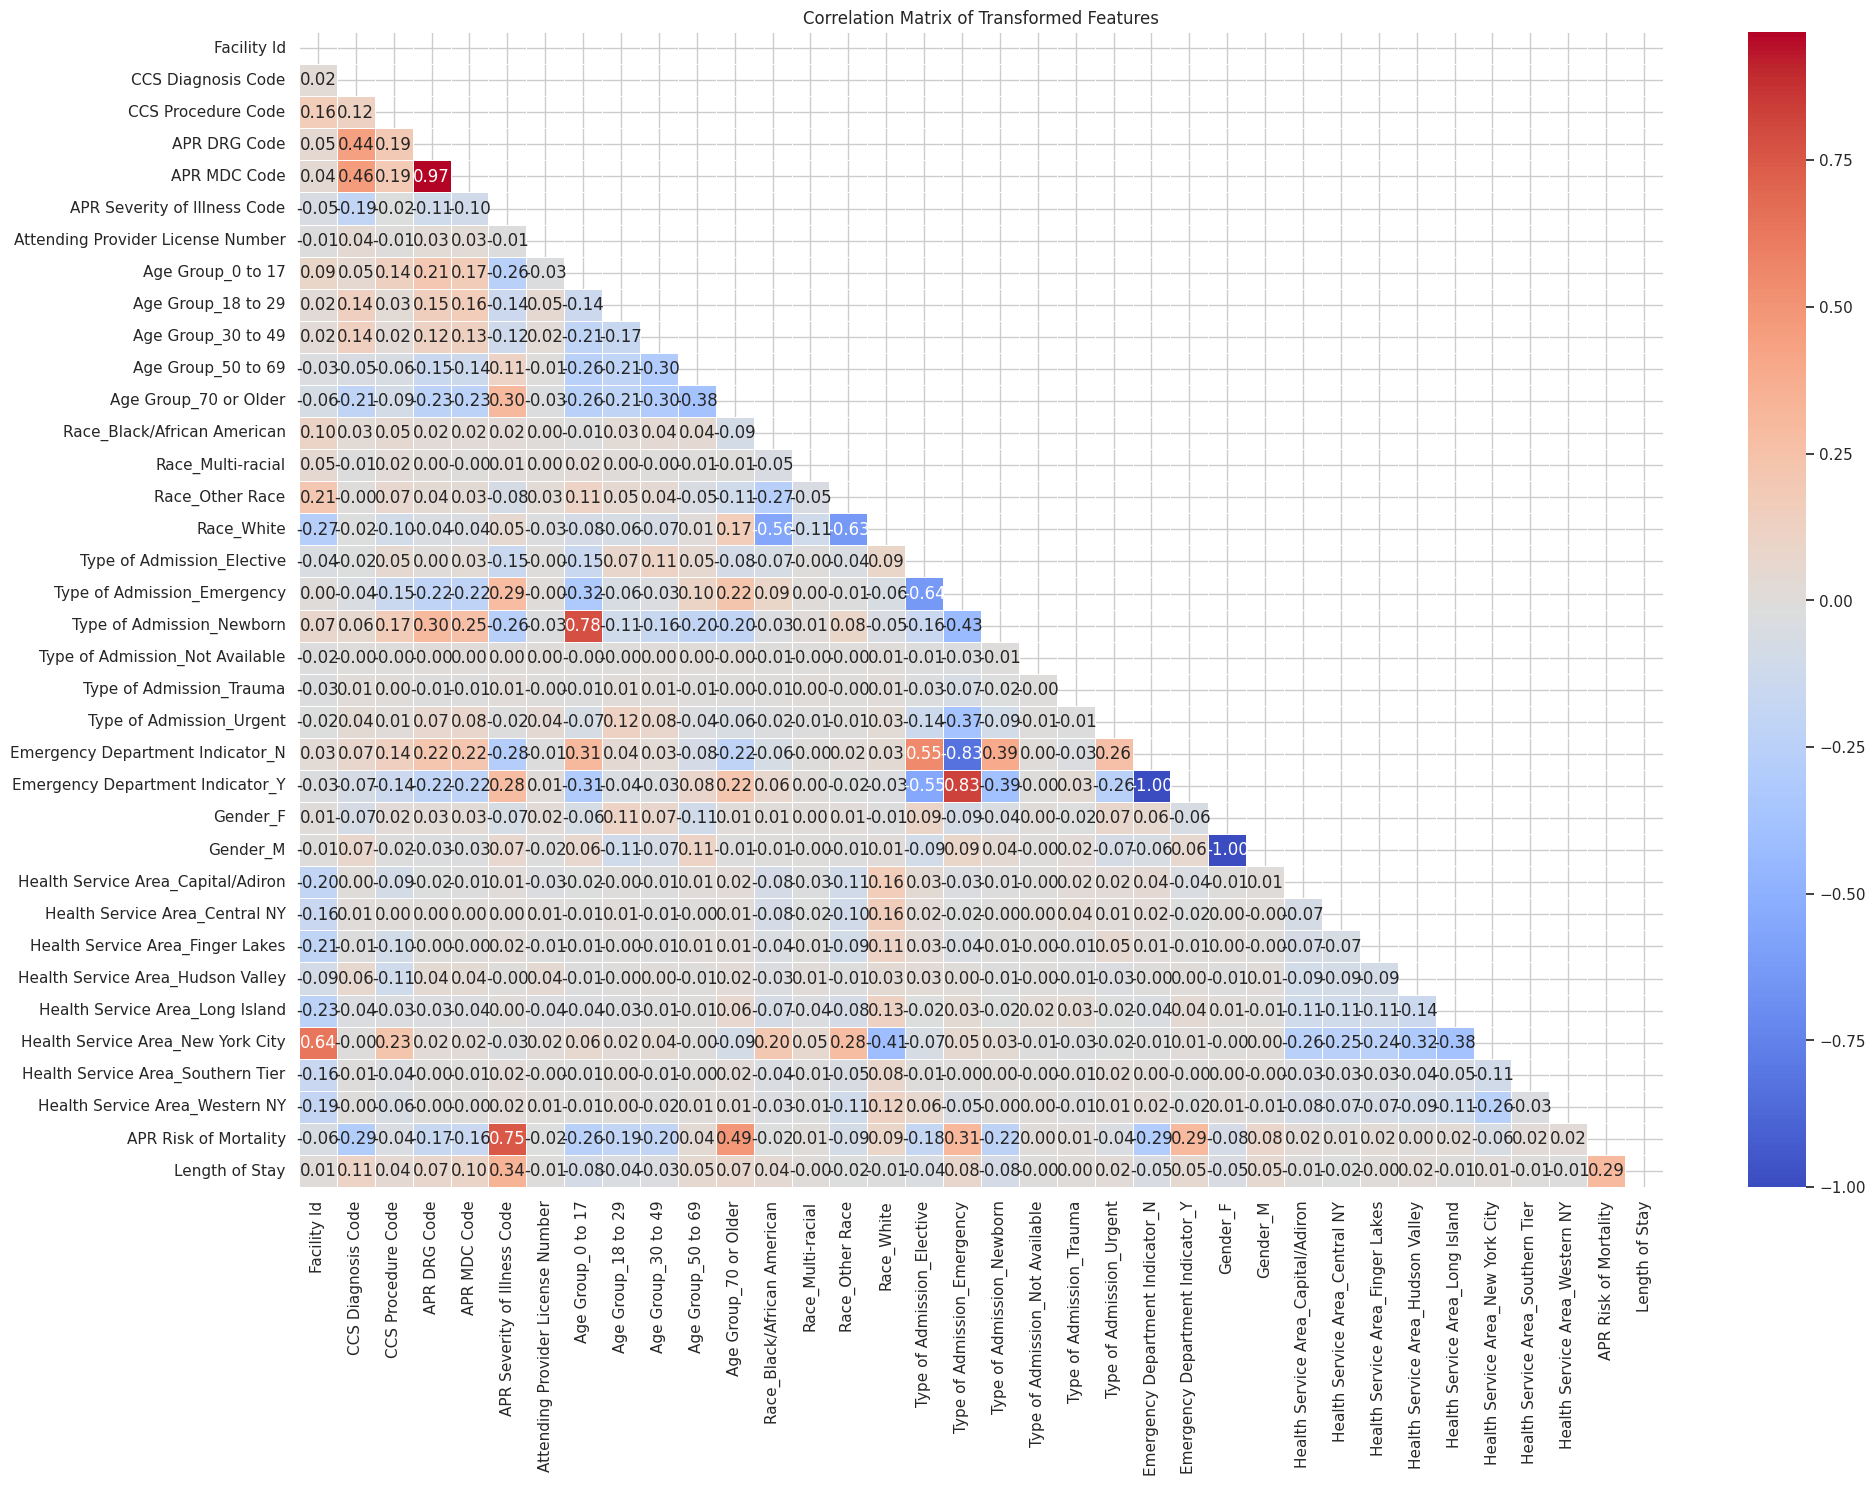

In [92]:
# Transform the data using the preprocessor
X_train_transformed = preprocessor.transform(X_train)

# Get the feature names after transformation
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
cat_ord_feature_names = preprocessor.named_transformers_['cat_ord'].named_steps['ordinal'].get_feature_names_out(categorical_ordinal)

# Combine the transformed feature names
all_feature_names = np.concatenate([numerical_features, cat_feature_names, cat_ord_feature_names])

# Create a DataFrame with transformed data
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)

# Concatenate the target variable with the transformed features
df_corr = pd.concat([X_train_transformed_df, y_train.reset_index(drop=True)], axis=1)

# Compute the correlation matrix
correlation_matrix = df_corr.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(22, 15))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Transformed Features")
plt.show()

In [77]:
## Correlation matrix
X_train_transformed = preprocessor.transform(X_train)

cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_feature_names])
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
df_corr = pd.concat([X_train_transformed_df, y_train.reset_index(drop=True)], axis=1)
correlation_matrix = df_corr.corr()
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Transformed Features")
plt.show()

ValueError: input_features should have length equal to number of features (6), got 7

### Evaluate

In [94]:
X_test, X_pred, y_test, y_pred = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=X_train['Race'])
y_pred = pipeline.predict(X_test)

In [95]:
def fairness_score_mse(X_test, y_true, y_pred):
    race_classes = X_test['Race'].unique()
    mse_scores = {}
    for race_class in race_classes:
        mask = (X_test['Race'] == race_class)
        if mask.sum() > 0:
            mse_scores[race_class] = mean_squared_error(y_true[mask], y_pred[mask])
            print("race_class: ", race_class)
            print("mse_scores[race_class]: ", mse_scores[race_class])
    max_mse = np.max(list(mse_scores.values()))
    min_mse = np.min(list(mse_scores.values()))
    max_difference = (max_mse - min_mse) / max_mse
    return max_difference
    
def score(X_test, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    race_diff = fairness_score_mse(X_test, y_true, y_pred)
    fairness_penalty = 0.0
    if race_diff > 0.15:
        fairness_penalty = race_diff - 0.15
    score = mse + fairness_penalty
    return max(0, score), race_diff
mean_squared_error(y_test, y_pred)
mse_score_final, race_diff = score(X_test, y_test, y_pred)
print("\n\nMSE Score Final:", mse_score_final)
print("Race Difference (Fairness Difference):", race_diff)

race_class:  White
mse_scores[race_class]:  46.9811686202019
race_class:  Other Race
mse_scores[race_class]:  55.83580504113432
race_class:  Black/African American
mse_scores[race_class]:  72.1718969915906
race_class:  Multi-racial
mse_scores[race_class]:  43.04135126918946


MSE Score Final: 54.01066289433071
Race Difference (Fairness Difference): 0.403627269569974


### Feature importance

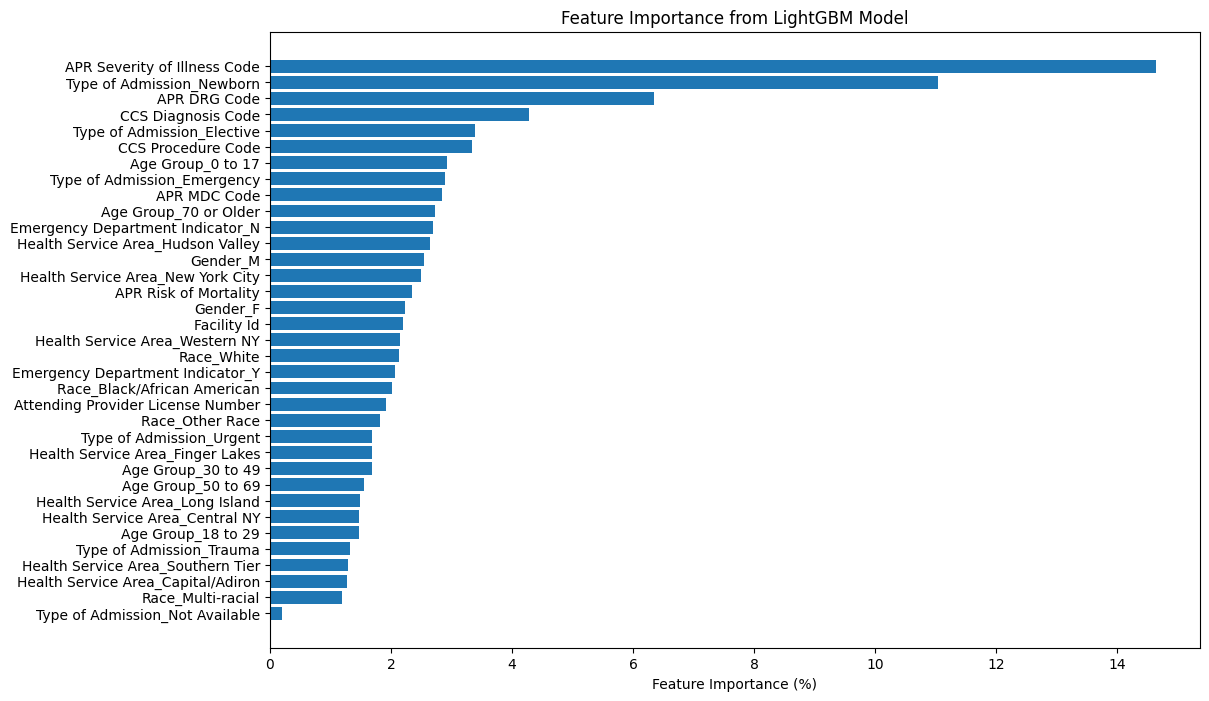

In [50]:
# lgbm_model = pipeline.named_steps['lgbmregressor']  # Extract the trained LightGBM model
lgbm_model = pipeline.named_steps['xgbregressor']  # Extract the trained LightGBM model


# Get feature importances
importances = lgbm_model.feature_importances_

# Get the feature names after preprocessing, including one-hot encoding
ohe = pipeline.named_steps['columntransformer'].transformers_[1][1].named_steps['onehot']
ohe_categories = ohe.categories_

# Create the expanded feature names list for one-hot encoded features
expanded_feature_names = numerical_features.copy()  # Start with numerical features

# Add the one-hot encoded categorical features
for cat, categories in zip(categorical_features, ohe_categories):
    expanded_feature_names.extend([f"{cat}_{category}" for category in categories])

# Add ordinal features if any
expanded_feature_names.extend(categorical_ordinal)

# Sort the feature importances and their corresponding feature names
sorted_idx = np.argsort(importances)[::-1]  # Sort importances in descending order
sorted_importances = importances[sorted_idx]
sorted_feature_names = np.array(expanded_feature_names)[sorted_idx]

# Convert importances to percentages
total_importance = sorted_importances.sum()
importance_percentages = (sorted_importances / total_importance) * 100

# Plot feature importances in descending order as percentages
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, importance_percentages)
plt.xlabel('Feature Importance (%)')
plt.title('Feature Importance from LightGBM Model')
plt.gca().invert_yaxis()  # To show the most important features on top
plt.show()

In [37]:
### 1.
# MSE Score Final: 53.77704455402941
# Race Difference (Fairness Difference): 0.40970890920190434

race_class:  White
mse_scores[race_class]:  46.9811686202019
race_class:  Other Race
mse_scores[race_class]:  55.83580504113432
race_class:  Black/African American
mse_scores[race_class]:  72.1718969915906
race_class:  Multi-racial
mse_scores[race_class]:  43.04135126918946


MSE Score Final: 54.01066289433071
Race Difference (Fairness Difference): 0.403627269569974

### 2. adicionando variavel 'Diagnosis Proc Interaction' que combina 'CCS Diagnosis Code' com 'CCS Procedure Code'
# MSE Score Final: 54.760753924769105
# Race Difference (Fairness Difference): 0.411606220207894

### 3. LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)   + sem a variavel do 2.
# MSE Score Final: 36.68166990790403
# Race Difference (Fairness Difference): 0.3612857010760505

### 4. LGBM ´+ forçar sentido da variavel  APR Risk of Mortality + sem Ethnicity
# MSE Score Final: 36.72103123543521
# Race Difference (Fairness Difference): 0.3323933940800881

### 5. Payment + Attending Provider License Number
# MSE Score Final: 36.23163572149231
# Race Difference (Fairness Difference): 0.32725346240618125

### 6. gender + emergency
# race_class:  White
# mse_scores[race_class]:  32.571233482022116
# race_class:  Other Race
# mse_scores[race_class]:  35.21512996372607
# race_class:  Black/African American
# mse_scores[race_class]:  47.02909239099319
# race_class:  Multi-racial
# mse_scores[race_class]:  31.931631003432


# MSE Score Final: 36.08127533707065
# Race Difference (Fairness Difference): 0.3210238730963176

#### 7. 
# race_class:  White
# mse_scores[race_class]:  32.49499708413222
# race_class:  Other Race
# mse_scores[race_class]:  35.477178168309436
# race_class:  Black/African American
# mse_scores[race_class]:  47.072115912527636
# race_class:  Multi-racial
# mse_scores[race_class]:  32.42157163799839


# MSE Score Final: 36.101719749765735
# Race Difference (Fairness Difference): 0.3112361530922852

## 8.
# race_class:  White
# mse_scores[race_class]:  32.36240509185237
# race_class:  Other Race
# mse_scores[race_class]:  35.7211523526624
# race_class:  Black/African American
# mse_scores[race_class]:  46.91379651829462
# race_class:  Multi-racial
# mse_scores[race_class]:  32.36310334564908


# MSE Score Final: 36.05126758309654
# Race Difference (Fairness Difference): 0.3101729662993221

## 9: XGBRegressor v1
race_class:  White
mse_scores[race_class]:  26.593855026043826
race_class:  Other Race
mse_scores[race_class]:  28.168797225579624
race_class:  Black/African American
mse_scores[race_class]:  38.804387033361394
race_class:  Multi-racial
mse_scores[race_class]:  24.031632299414746


MSE Score Final: 29.47241098694825
Race Difference (Fairness Difference): 0.38069805667194356


### 10: XGBRegressor + hyperparameter tunning
# race_class:  White
# mse_scores[race_class]:  35.99393909415872
# race_class:  Other Race
# mse_scores[race_class]:  41.49352348931759
# race_class:  Black/African American
# mse_scores[race_class]:  53.21934426871234
# race_class:  Multi-racial
# mse_scores[race_class]:  35.67481732800174


# MSE Score Final: 40.701071369790895
# Race Difference (Fairness Difference): 0.3296644703498354

### 11: XGBRegressor + hyperparameter tunning v2
# race_class:  White
# mse_scores[race_class]:  36.055383085436596
# race_class:  Other Race
# mse_scores[race_class]:  41.60331765328127
# race_class:  Black/African American
# mse_scores[race_class]:  53.53967315243259
# race_class:  Multi-racial
# mse_scores[race_class]:  35.21933521987431


# MSE Score Final: 40.8301776467094
# Race Difference (Fairness Difference): 0.34218247616862585

#### 12. XGBRegressor + hyperparameter tunning v3
# ace_class:  White
# mse_scores[race_class]:  34.41161329089875
# race_class:  Other Race
# mse_scores[race_class]:  38.80006196600461
# race_class:  Black/African American
# mse_scores[race_class]:  50.85926505039356
# race_class:  Multi-racial
# mse_scores[race_class]:  32.95570207171092


# MSE Score Final: 38.72542830354205
# Race Difference (Fairness Difference): 0.3520216613618584

/tmp/ipykernel_15799/362504688.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Race", y="MSE Score", palette="coolwarm")


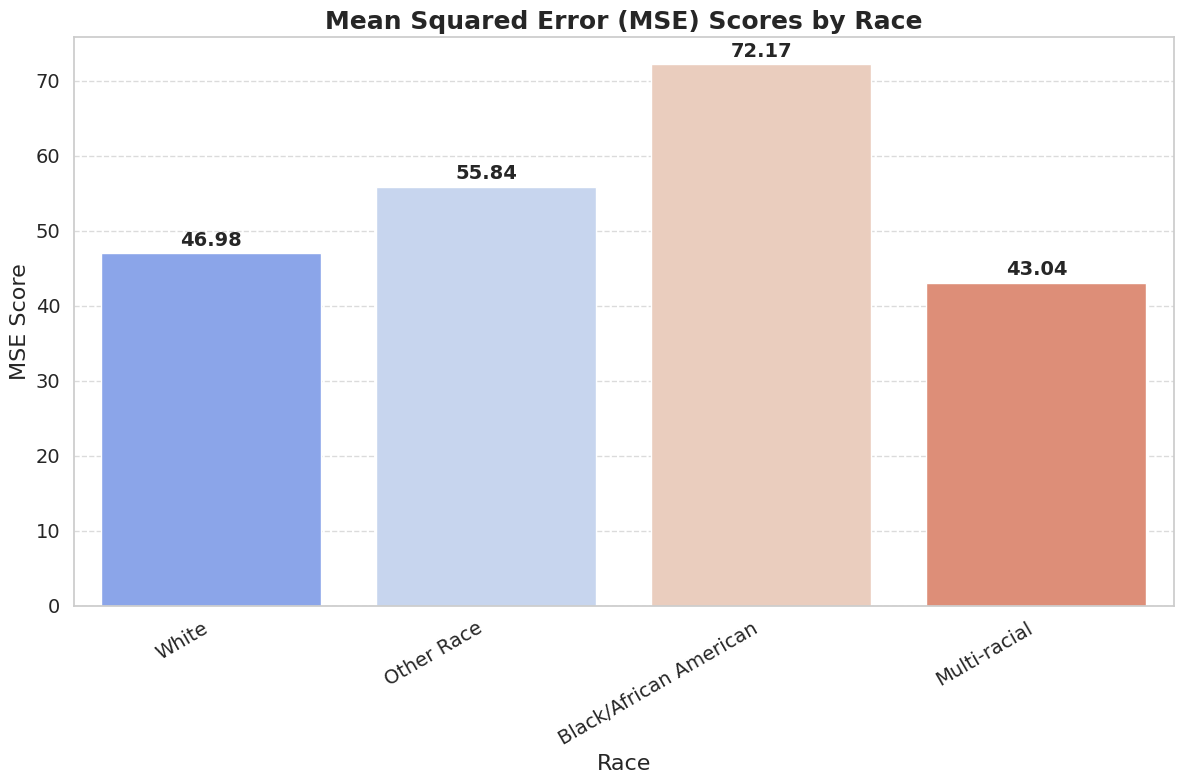

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Provided data
data = {
    "Race": ["White", "Other Race", "Black/African American", "Multi-racial"],
    "MSE Score": [46.9811686202019, 55.83580504113432, 72.1718969915906, 43.04135126918946]
}
df_results = pd.DataFrame(data)

# Create a bar plot using seaborn
plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility
sns.barplot(data=df_results, x="Race", y="MSE Score", palette="coolwarm")

# Add labels and title
plt.title("Mean Squared Error (MSE) Scores by Race", fontsize=18, fontweight="bold")  # Larger title font
plt.xlabel("Race", fontsize=16)  # Increase x-axis label font size
plt.ylabel("MSE Score", fontsize=16)  # Increase y-axis label font size
plt.xticks(rotation=30, fontsize=14, ha='right')  # Rotate and enlarge x-axis labels
plt.yticks(fontsize=14)  # Increase size of y-axis values

# Annotate bars with values (larger font size)
for index, row in df_results.iterrows():
    plt.text(index, row["MSE Score"] + 1, f"{row['MSE Score']:.2f}", ha='center', fontsize=14, fontweight="bold")  # Larger font for annotations

# Add gridlines for clarity
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_15799/2962463778.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Race", y="MSE Score", palette="coolwarm")


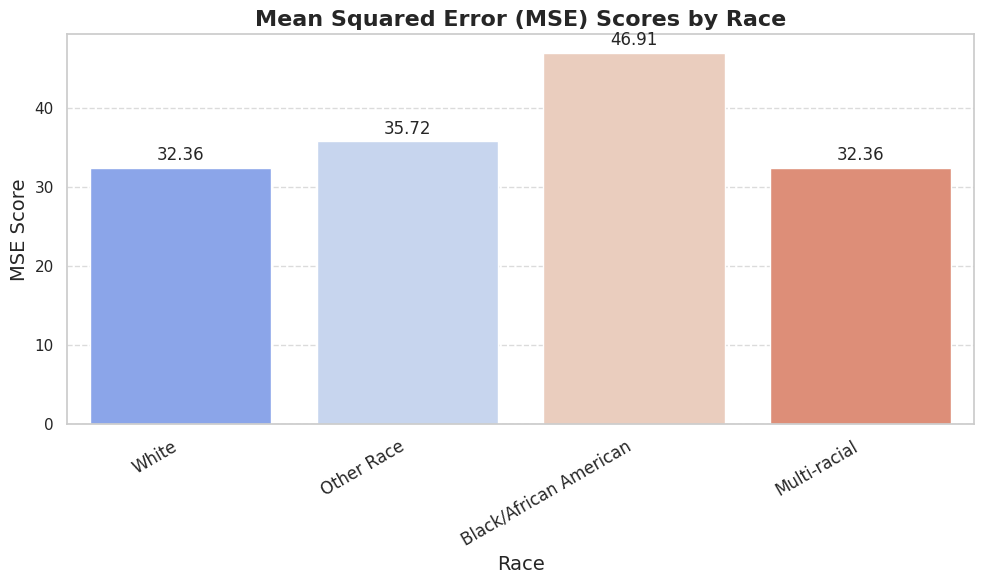

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Provided data
data = {
    "Race": ["White", "Other Race", "Black/African American", "Multi-racial"],
    "MSE Score": [32.36240509185237, 35.7211523526624, 46.91379651829462, 32.36310334564908]
}
df_results = pd.DataFrame(data)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Race", y="MSE Score", palette="coolwarm")

# Add labels and title
plt.title("Mean Squared Error (MSE) Scores by Race", fontsize=16, fontweight="bold")
plt.xlabel("Race", fontsize=14)
plt.ylabel("MSE Score", fontsize=14)
plt.xticks(rotation=30, fontsize=12, ha='right')  # Rotate for better readability

# Annotate bars with values
for index, row in df_results.iterrows():
    plt.text(index, row["MSE Score"] + 1, f"{row['MSE Score']:.2f}", ha='center', fontsize=12)

# Add gridlines for clarity
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_15799/2592235682.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Race", y="MSE Score", palette="coolwarm")


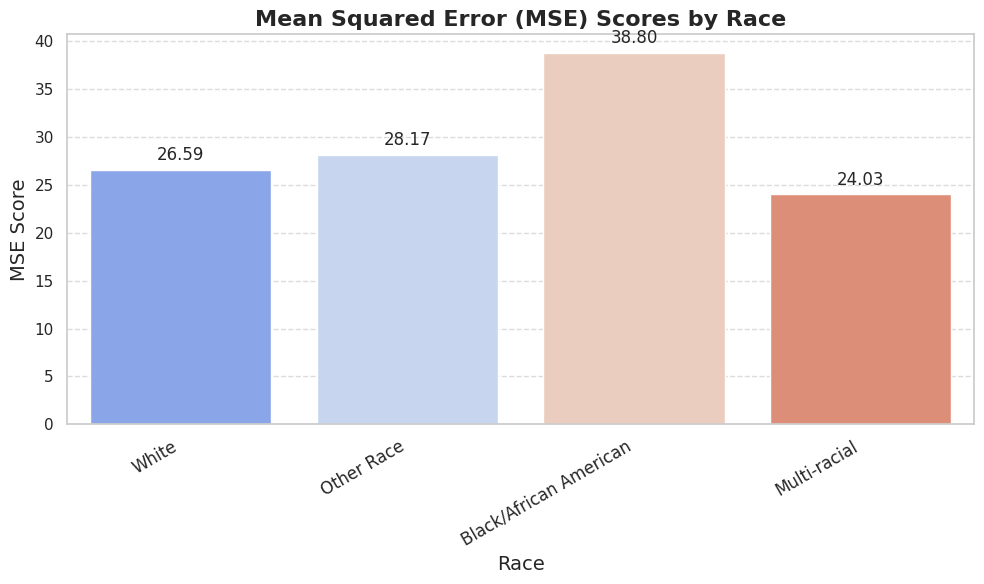

In [99]:
# Prepare the data in a pandas DataFrame
data = {
    "Race": ["White", "Other Race", "Black/African American", "Multi-racial"],
    "MSE Score": [26.593855026043826, 28.168797225579624, 38.804387033361394, 24.031632299414746]
}
df_results = pd.DataFrame(data)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Race", y="MSE Score", palette="coolwarm")

# Add labels and title
plt.title("Mean Squared Error (MSE) Scores by Race", fontsize=16, fontweight="bold")
plt.xlabel("Race", fontsize=14)
plt.ylabel("MSE Score", fontsize=14)
plt.xticks(rotation=30, fontsize=12, ha='right')  # Slight rotation for better readability

# Annotate the bars with their values
for index, row in df_results.iterrows():
    plt.text(index, row["MSE Score"] + 1, f"{row['MSE Score']:.2f}", ha='center', fontsize=12)

# Show gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

### Serialization 

In [56]:
TMP_DIR = ''
with open(os.path.join(TMP_DIR, 'columns.json'), 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)
with open(os.path.join(TMP_DIR, 'dtypes.pickle'), 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
joblib.dump(pipeline, os.path.join(TMP_DIR, 'pipeline.pickle'));